In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
from tqdm.notebook import tqdm
from PIL import Image
import requests
from io import BytesIO

In [41]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [3]:
import keras,os
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump

In [4]:
pd.set_option('display.max_rows', None)

In [4]:
#Loading the 48k data points which we processed earlier
data= pd.read_pickle('G:\Jupyter Notebook\Amazon recommendor\\pickles\\48k_apparel_data')

In [5]:
data.sample(10)

,asin,product_type_name,color,brand,medium_image_url,title
7777,B06Y3FZX1X,SHIRT,Black,Rock Rebel,https://images-na.ssl-images-amazon.com/images...,Bride of Frankenstein Juniors Green Bride T-Shirt
56199,B01F89WH2Q,BOOKS_1973_AND_LATER,White,BINB,https://images-na.ssl-images-amazon.com/images...,Women Play Card Of Ace Of Spades T-shirt Funny
17998,B071HBT9F1,SHIRT,Blush,FIFTEEN TWENTY,https://images-na.ssl-images-amazon.com/images...,Fifteen Twenty Blush Short Sleeve Shirttail Tee
10847,B073V16YVS,SHIRT,White,WILLTOO,https://images-na.ssl-images-amazon.com/images...,Clearance! WILLTOO Women Fashion Stripe Long S...
33944,B074KHZQ2T,SHIRT,Blue,Miss Chievous,https://images-na.ssl-images-amazon.com/images...,Miss Chievous Juniors' Sequined Embellished He...
33730,B071JG858L,SHIRT,Blue,Miller,https://images-na.ssl-images-amazon.com/images...,Miller Lite Ladies Can Logo Tee Shirt
26304,B071X5QFYT,SHIRT,Black,Jess N Jane,https://images-na.ssl-images-amazon.com/images...,"Jess & Jane ""Wine Fest"" Cotton Top in Black 14..."
56956,B06XYMHQ6R,SHIRT,Assorted Colors,Erin London,https://images-na.ssl-images-amazon.com/images...,"Women's Crew Neck, 3/4 Inch Sleeve Top, Assort..."
35580,B06XFHX233,SHIRT,Blue,boxercraft,https://images-na.ssl-images-amazon.com/images...,Navy Blue Triblend Relaxed Longer V Neck Tee
59766,B00ZCP5FTO,SHIRT,White,YICHUN,https://images-na.ssl-images-amazon.com/images...,YICHUN Girl's T-Shirts Panda Printing Short Ba...


<h1>1. Data pre processing</h1>

<ol>
<li>Removing punctuations</li>
<li>Removing stop words</li>
<li>Changing all text to lower case</li>
</ol>

In [8]:
#This holds all the punctutations and str format of number 1-10
punctuations = [i for i in string.punctuation]+[str(i) for i in range(0,10)]

#This holds the stop words in english vocabulary
stop_words = stopwords.words('english')

#This method will take text as input and remove all the punctuations form it
def remove_punctutation(string):
    
    #This will replace punctuations with empty space
    for i in (punctuations):
        if(i in string):
            string=string.replace(i," ")
            
    #This holds the text with removed punctuations
    punc_rem_string=string
    
    #Assigning the string to empty
    string=""
    
    #This will remove the stop words for punctuation removed text
    for i in punc_rem_string.split(" "):
        if(i not in stop_words and i!=""):
            string=string+" "+i.strip()
            
    return string.strip().lower()

In [9]:
#Applying remove_punctuation on the title column
data['title'] = data.iloc[:,[5]].applymap(remove_punctutation)

<h1>2. Using BOW method to recommend similar prodcuts</h1>
<ol>
    <li>We will use Countvectorizer() to vectorizer the text data in titles</li>
    <li>For visualization we will print the heatmap and image of product</li>
    <li>we will use euclidean distance to define the similarity between two sentences</li>

In [15]:
#Vectorizing the title text data, this will return a sparse matrix
vectorizer = CountVectorizer()
Vec = vectorizer.fit_transform(data['title'])

<b>2.2 Creating all methods that we will use to display top products

In [59]:
#This method will give the top products (ID is the query point and TOP is the number of recommended products to be shown)
#Vec is the vectorizer form of text and top defines the total number of recommendation to be shown
def top_fashion(Vec,id,top=5):
    
    #This will store the euclidean distance between 
    euc_dist = euclidean_distances(Vec[:],Vec[id])
    
    #This will store the index of values that have least euc_dist
    top_fasion = np.argsort(euc_dist.reshape(1,-1))[0][0:top+1]
    
    return top_fasion


#This will return a list with all unique words in a title
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist


#This will count the number of times a word is repeated in the title
#sentence is the query point and word is what we want to compare the title
def count_word(sentence, word):
    x = 0
    for i in sentence.split():
        if i==word:
            x+=1
    return x

#print (count_word("tha a atedta a","a"))

#This method will return info about if its present in the title 
def title_information(top_titles,unique_word_title):
    
    #title_info holds the value of each words in a title as (word,count,if_present)-->0 meaning not present and 1 meaning presen
    
    #example - 
    #Query -> title:  "hello world how are you" - this will be returned in below format
    #Query compared with : "hello great world i am fine"
    #This will be returned - [[(hello,1,1),(great,1,0),(world,1,1,(i,1,0)(am,1,0),(fine,1,0))],....]
    #and will be stored in title_info
    title_info=[]
    
    #The first variable holds the query ID title i.e based on what we want to recommend products
    first = top_titles.tolist()[0][0].split()
    
    #print("I am first - ",first)
    for i in range(0,len(top_titles.tolist()[0])):
        
        title_values=[]

        for j in (unique_word_title[i].split()):
            
            repeat=count_word(top_titles.tolist()[0][i],j)

            if(j in first):

                title_values.append((j,repeat,1))
            else:
                title_values.append((j,repeat,0))
                #print("Came in else")

        title_info.append(title_values)  
        
    return title_info    

#This will display the total ID returned in top_list
#The title_info holds title information in format :- [[(hello,1,1),(great,1,0),(world,1,1,(i,1,0)(am,1,0),(fine,1,0))],....]
#top_ids holds all the top ids of recommended products
#cmap holds the color pallette for the heatmap
def plot_visuals(title_info,top_ids,cmap="YlGnBu"):
    
    #This will store euclidean distance of all recommended Ids
    euc_dist=euclidean_distances(Vec[top_ids],Vec[top_ids[0]])
   
    #We will use this to retrieve the IDs from top_ids
    count=0
    
    #This loop will run for all the recommended titles and print the heatmap and image of the prodcuts
    for i in title_info:
        #print(i)
        
        #The will store the annotations for the title
        annot=[]
        #This for loop will return the annot we will use on heatmap as annotations
        #We will annot the word as 0 if it is not present in the query title
        #We will annot the word as the total number of time word appears, if it is present in the query title
        for j in i:
            if(j[2]==0):
                annot.append(0)
            else:
                annot.append(j[1])
        
        print("Title : ",data.iloc[top_ids[count],5])
        print("ASIN : ",data.iloc[top_ids[count],0])
        print("Euclidean distance : ",euc_dist[count][0])
        
        #we will plot heatmap on the right side and image on the left side
        fig,ax = plt.subplots(1,2,figsize=(30,6))
        
        #This will display the heatmap
        sns.heatmap(cmap=cmap,data=[annot],linewidth=0.005,linecolor='black',ax=ax[0],annot=True,xticklabels=[j[0] for j in i])
        
        #Storing the URL of the image and saving the image in variable img
        URL = str(data.iloc[top_ids[count],4])
        response = requests.get(URL)
        img = Image.open(BytesIO(response.content))
        
        #Displaying the image of product
        ax[1].imshow(img)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        
        plt.show()
        
        count+=1

In [58]:
def plot_heatmap_image(Vec,data,id,top=5,cmap="YlGnBu"):
    
    #This will hold the ID of top recommended products
    top_ids = top_fashion(Vec,id,top)
    
    #This will hold the the titles of the IDs in top_ids
    top_titles = data.iloc[top_ids,5].values.reshape(1,-1)
    
    unique_word_title=[]
    
    #This will remove repeated words in titles for all titles in top_titles and store it in unique_word_title
    for i in (top_titles.tolist()[0]):
        unique_word_title.append(" ".join(unique_list(i.split())))
        
    #print("i am unique word list - ",unique_word_title)
    
    #title_info holds the value of each words as (word,count,if_present)
    '''title_info=[]
    
    #The first variable holds the query ID title
    first = top_titles.tolist()[0][0].split()
    #print("I am first - ",first)
    for i in range(0,len(top_titles.tolist()[0])):
        
        
        title_values=[]

        for j in (unique_word_title[i].split()):
            
            repeat=count_word(top_titles.tolist()[0][i],j)

            if(j in first):

                title_values.append((j,repeat,1))
            else:
                title_values.append((j,repeat,0))
                #print("Came in else")

        title_info.append(title_values) '''
    
    title_info = title_information(top_titles,unique_word_title)
        
    plot_visuals(title_info,top_ids,cmap=cmap)
        
    return (title_info)

Title :  tiger hill ladies texas flag fishing shirt short sleeves
ASIN :  B01GGQ6VWC
Euclidean distance :  0.0


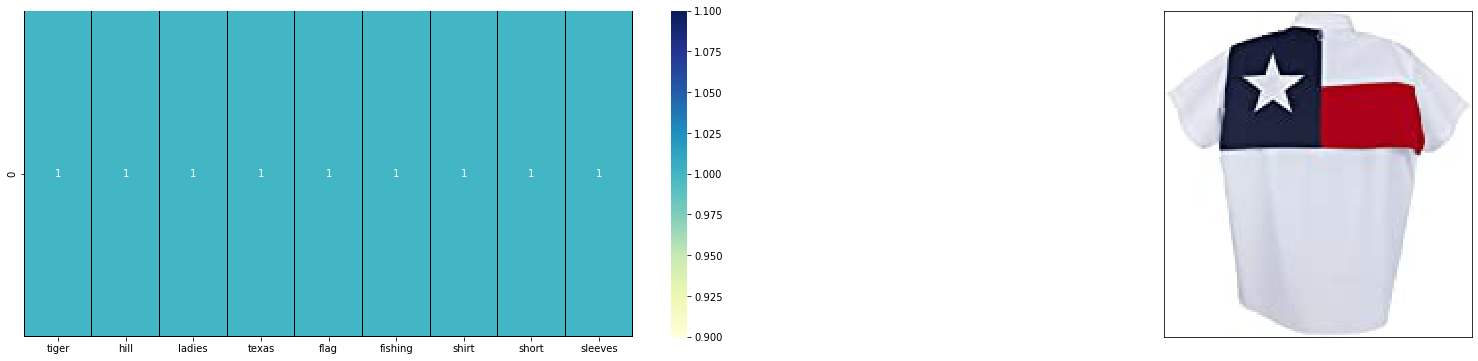

Title :  tiger hill ladies pink gingham fishing shirt short sleeves
ASIN :  B01JJCJWJE
Euclidean distance :  2.0


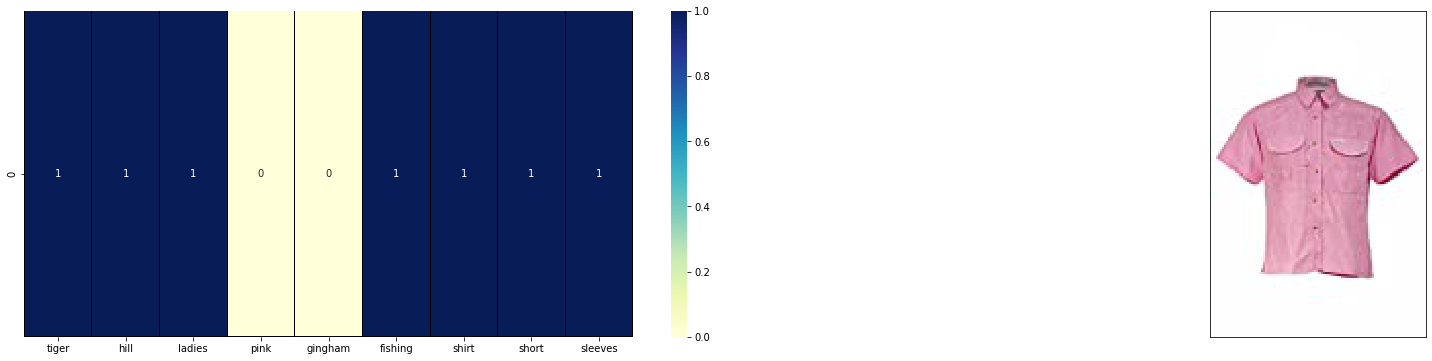

Title :  tiger hill mardi gras ladies fishing shirt short sleeves
ASIN :  B01KYGNYO8
Euclidean distance :  2.0


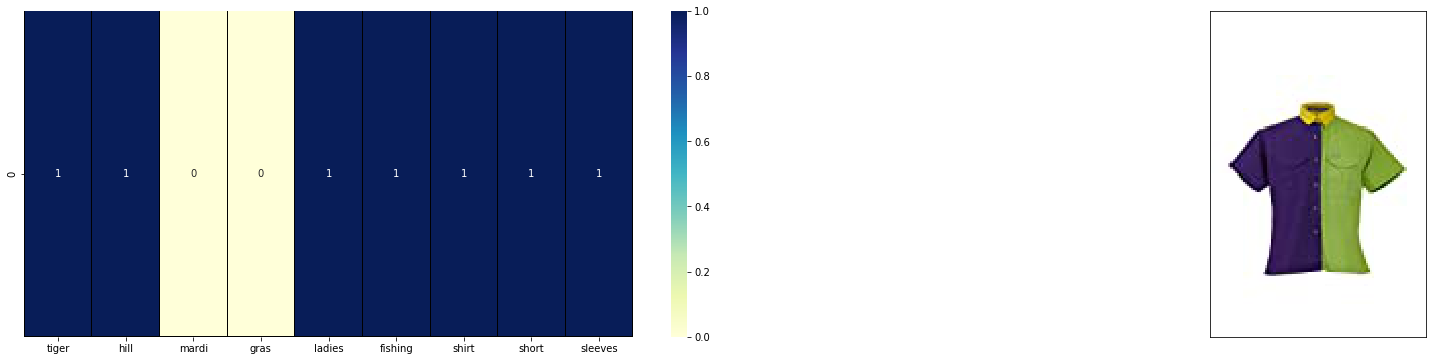

Title :  ladies texas flag button down shirt
ASIN :  B01CF3Q6SO
Euclidean distance :  2.6457513110645907


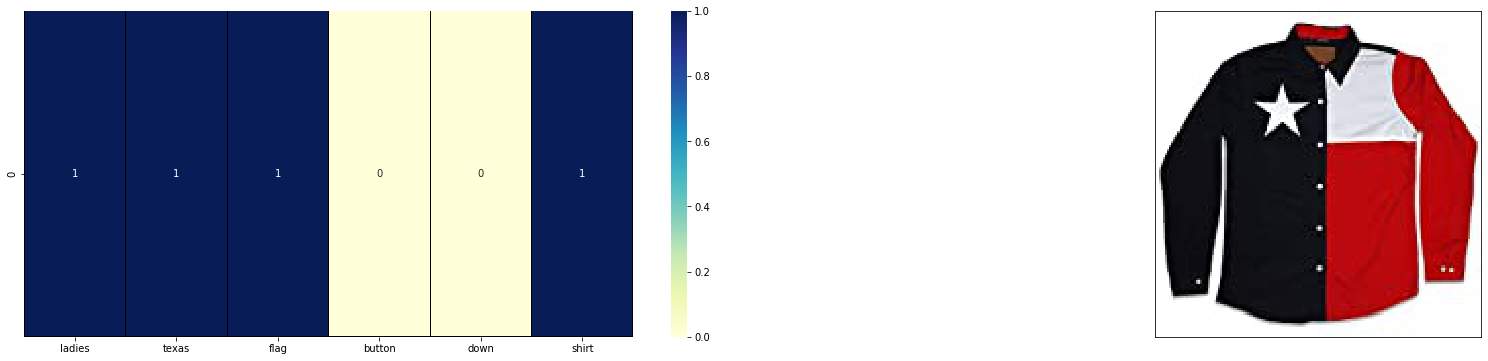

Title :  ladies burnout henley shirt
ASIN :  B01LZ514K9
Euclidean distance :  3.0


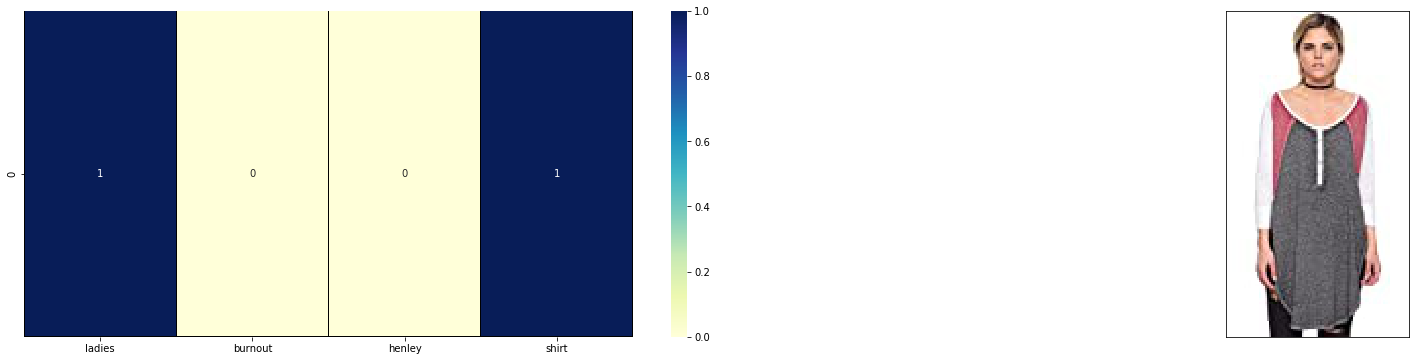

Title :  hop vine ladies shirt
ASIN :  B07282NDVF
Euclidean distance :  3.0


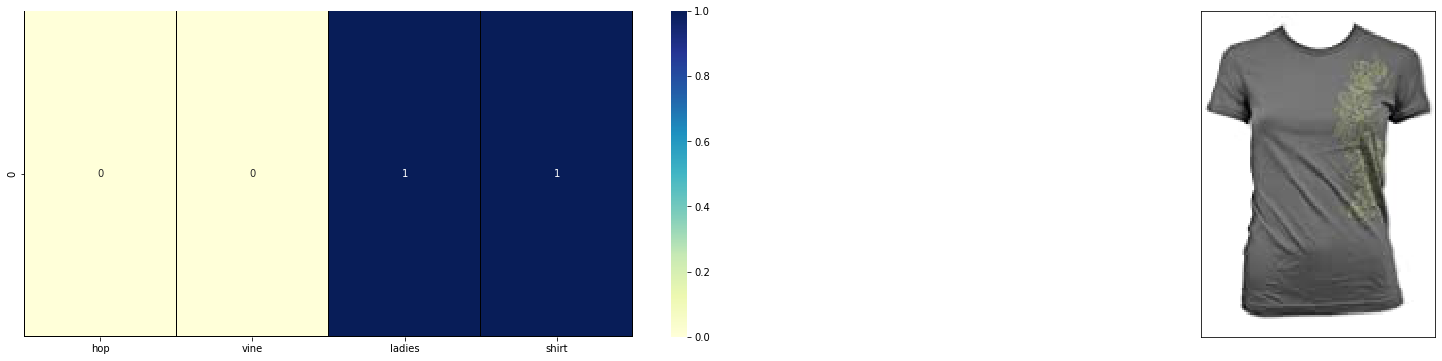

Title :  regatta ladies jenna short sleeve shirt
ASIN :  B00VRV9MVY
Euclidean distance :  3.0


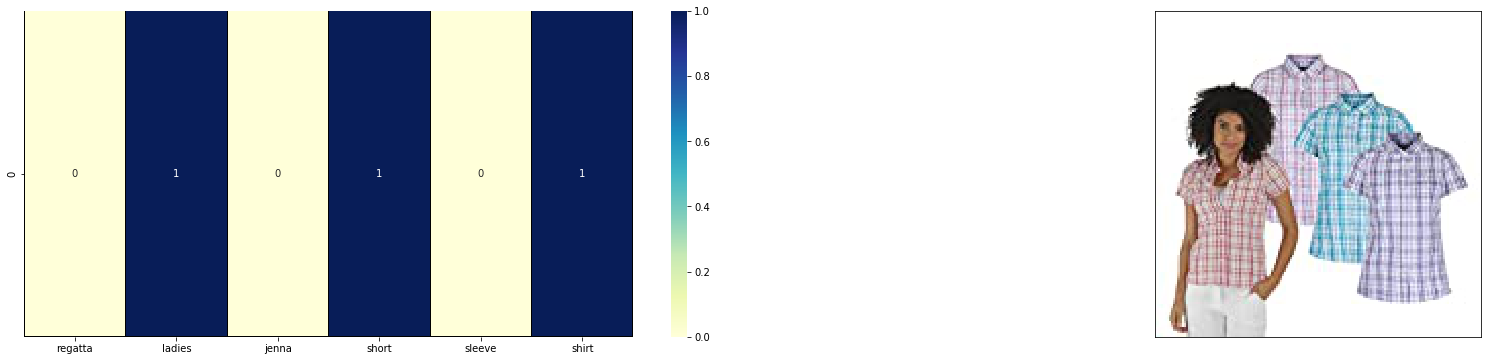

Title :  women short sleeve shirt
ASIN :  B074MPHZNM
Euclidean distance :  3.0


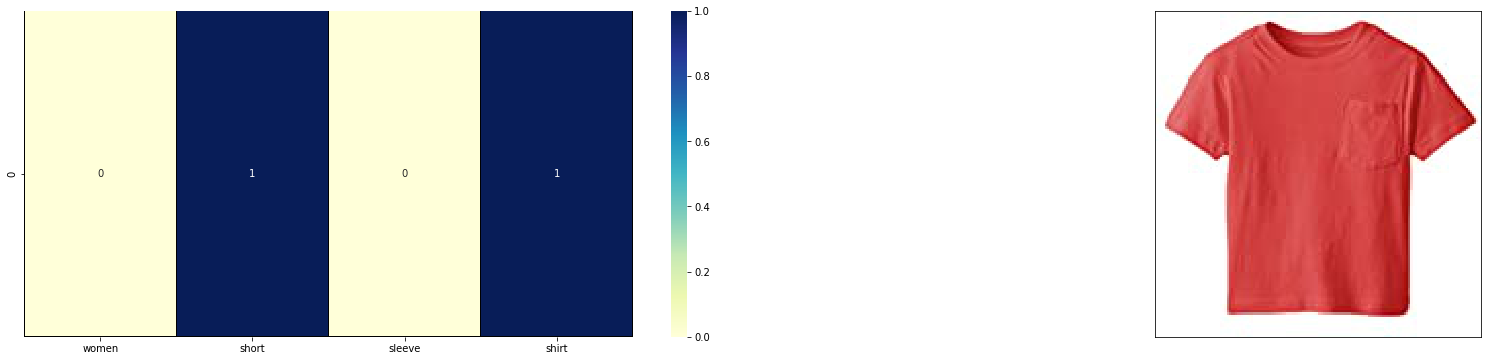

Title :  armani collezioni ladies shirt
ASIN :  B01LX4VLRB
Euclidean distance :  3.0


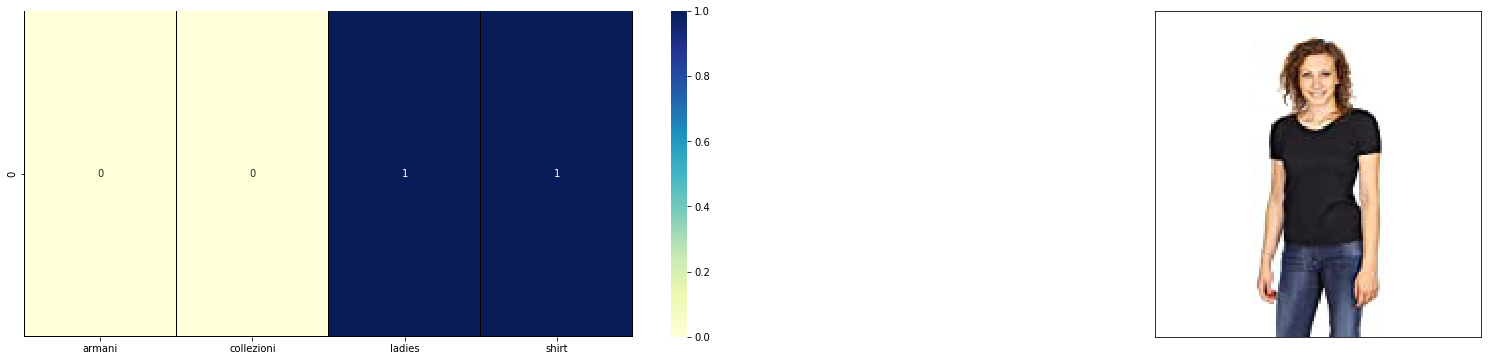

Title :  dodge demon ladies shirt
ASIN :  B06ZZ8FVY7
Euclidean distance :  3.0


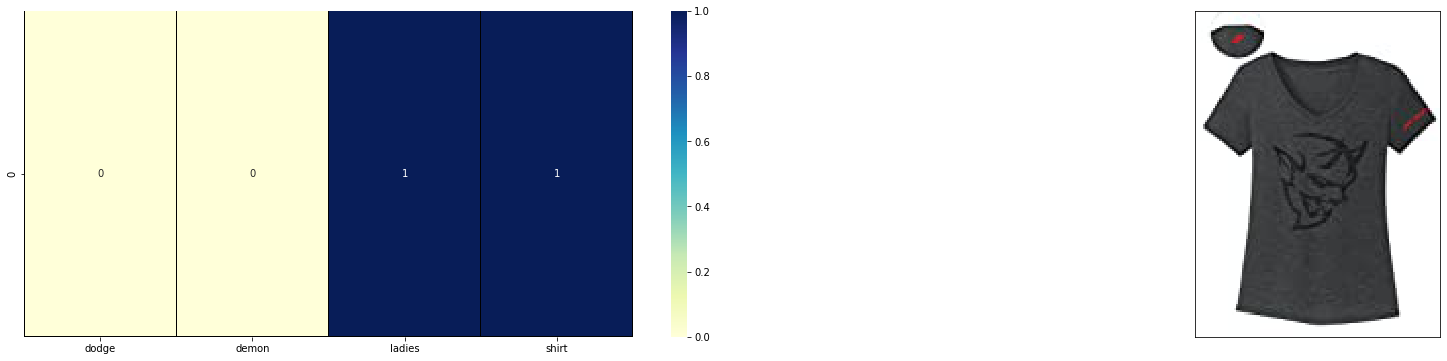

Title :  ladies heart boost shirt
ASIN :  B06XY2Q55P
Euclidean distance :  3.0


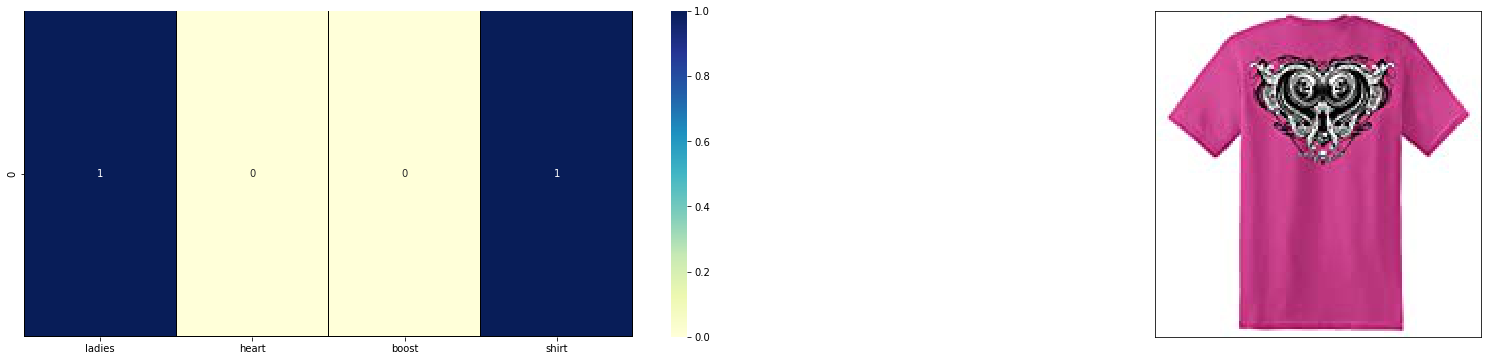

In [16]:
a=plot_heatmap_image(data,38890,top=10)

<h1>3. Using TF-IDF to recommend products</h1>
<ol>
    <li>Data pre-processing :- Remove title with less than 4 words</li>
    <li>Find tf_idf of each title</li>
    <li>Display the top recommended products</li>
    
    

<h3>3.1.0 Data pre-processing :- Remove title with less than 4 words and words that have less than 3 letters

In [91]:
#Checking the shape of dataframe before removing the title with less than 4 words
data.shape

(48768, 6)

In [96]:
#We will return null for titles that have words less than 4
#We will return the text unchanged if the total words in more than 4
def count_length(text):
    
    if(len(text.split())>4):
        return text
    else:
        return np.nan

In [ ]:
#Applying the count_length method on title column in our dataframe
data['title']=data.iloc[:,[5]].applymap(count_length)

In [99]:
#Dropping the rows with null values
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

In [100]:
#Checking the shape after removing the title with less than 4 words
data.shape

(47486, 6)

In [103]:
#Saving the dataframe
data.to_pickle('G:\Jupyter Notebook\Amazon recommendor\\pickles\\47k_apparel_data')

<h3>3.1.1 Remove words from title which has length less than 2 letters

In [196]:
#This method will remove the word that has less than 2 characters
def remove_word(text,len_word=1):
    
    text_words = text.split()
    string =''
    for i in text_words:
        if(len(i)>len_word):
            string = string+" "+i
        else:
            continue
    return string.strip()       

In [197]:
#removing words with less than 2 characters
data['title']=data.iloc[:,[5]].applymap(remove_word)

In [199]:
#Save the pickle file
data.to_pickle('G:\Jupyter Notebook\Amazon recommendor\\pickles\\47k_apparel_data')

In [4]:
#Reading the dataframe
data=pd.read_pickle('G:\Jupyter Notebook\Amazon recommendor\\pickles\\47k_apparel_data')

<h3>3.2.0 Find tf_idf of the titles

In [9]:
#Calculating the tf-idf values of each word using the TfidfVectorizer()
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(data['title'])

In [201]:
vec

<47486x17635 sparse matrix of type '<class 'numpy.float64'>'
	with 434749 stored elements in Compressed Sparse Row format>

<h3>3.3.0 Display the top products

In [5]:
#This will return index of top products which has less euc_dist 
def top_fashion_tfidf(vec,id,top=5):
    
    euc_dist = euclidean_distances(vec[:],vec[id])
    top_fasion = np.argsort(euc_dist.reshape(1,-1))[0][0:top+1]
    
    return top_fasion


In [6]:
#This will plot the heatmap and image of products
#id is the query point
#top_product is the top recommeneded product
#xticklabels is a list that holds all words of a title
#annot is a list that holds tf-idf value for each word
#cmap is used to define the pallette color of the heatmap
def plot_heatmap_image_tfidf(id,top_product,xticklabels,annot,cmap='Blues'):
    
    #This holds the euclidean distance of query point the the recommended product ids
    euc_dist=euclidean_distances(Vec[id],Vec[top_product[0]])
    
    #We will plot heatmap on the left side and image on the right side
    fig,ax = plt.subplots(1,2,figsize=(30,6))
    
    #Plotting the heatmap
    sns.heatmap(cmap=cmap,data=[annot],linewidth=0.005,linecolor='black',ax=ax[0],annot=True,xticklabels=xticklabels)
    
    #Retrieving the image and storing it in img
    URL = str(data.iloc[id,4])
    response = requests.get(URL)
    img = Image.open(BytesIO(response.content))
    
    #Printing info about the product
    print("Title : ",data.iloc[id,5])
    print("ASIN : ",data.iloc[id,0])
    print("Euclidean distance :", euc_dist[0][0])
    
    #Displaying the image on the right side
    ax[1].imshow(img)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
        
    plt.show()

In [31]:
#We will use this same method to display both tf-idf and k-means recommended products
#data is the dataframe
#vec holds tf-idf vectorizer
#top is total products to be displayed
#model if tf-idf then tf-idf based products will be displayed, else k-means based products will be displayed
def plot_visuals_tfidf(data,vec,id,top=5,model='tf-idf'):
    
    if model == 'tf-idf':
        
        top_product=top_fashion_tfidf(vec,id,top=top)
        
    else:
        
        top_product=top_fashion_KMeans(vec,id,top=top)
    
    for i in top_product:
        
        #This will hold the index at which the value is non zero
        non_zero_features=np.nonzero(vec[i].toarray())[1]
        
        #This will get the feature name, where the tf-idf value is greater than 0
        title_word=[vectorizer.get_feature_names()[i] for i in non_zero_features]
        
        #This will store the tf-idf value of the index where it is not zero
        title_tfidf = [vec[i].toarray()[0][j] for j in non_zero_features]
        
        #This will zip make word as dictionary and value as its corresponding tf-idf
        word_tfidf=dict(zip(title_word,title_tfidf))
        
        xticklabels = data.iloc[i,5].split()
        
        annot=[]
        
        for j in xticklabels:
            try:
                annot.append(word_tfidf[j])
            except:
                annot.append(0)
        
        plot_heatmap_image_tfidf(i,top_product,xticklabels,annot)


<h3>Showing top products using TF-IDF

Title :  personal touch blue zebra women plus size blouse
ASIN :  B01MZIY0JV
Euclidean distance : 0.0


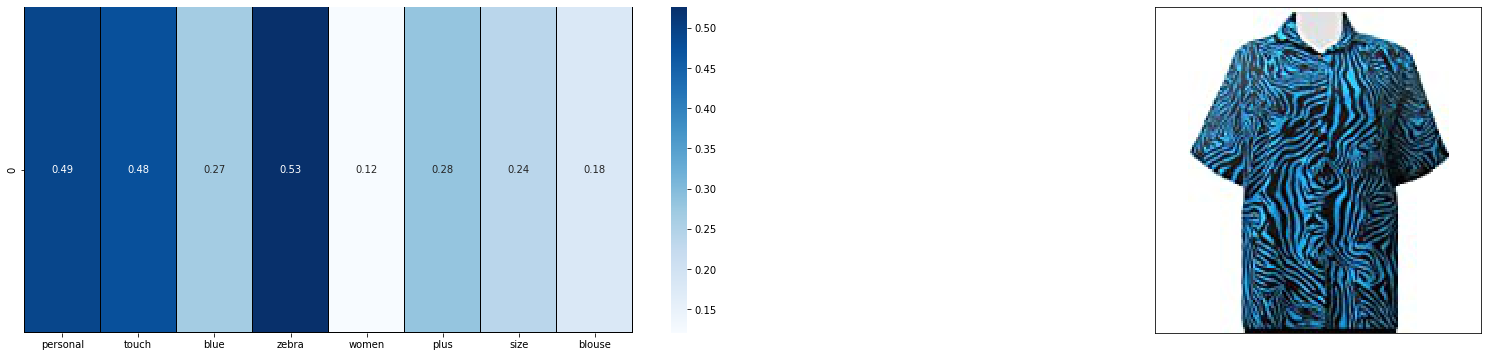

Title :  personal touch women plus size red neck top
ASIN :  B01LX7M2CL
Euclidean distance : 2.449489742783178


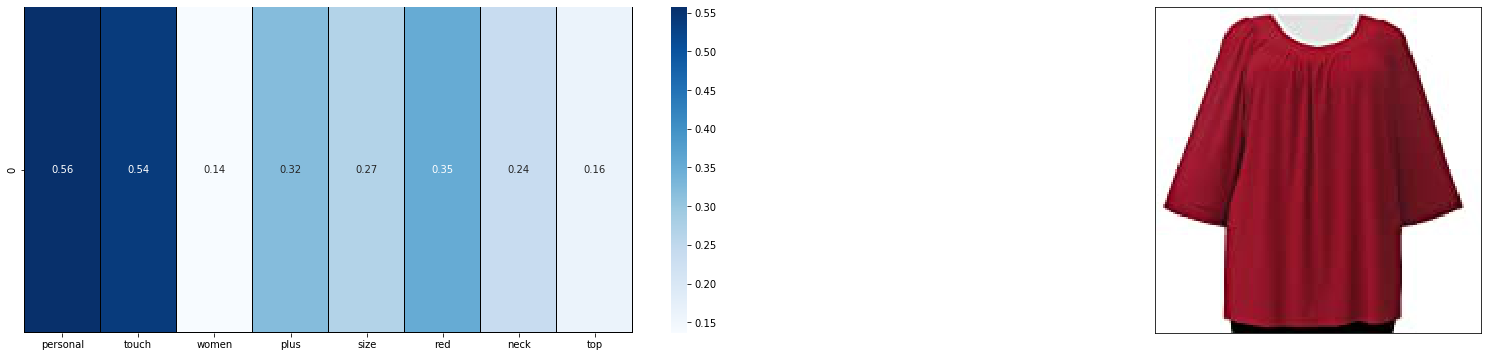

Title :  personal touch women plus size light blue sleeve neck tunic
ASIN :  B01JAXZY94
Euclidean distance : 2.449489742783178


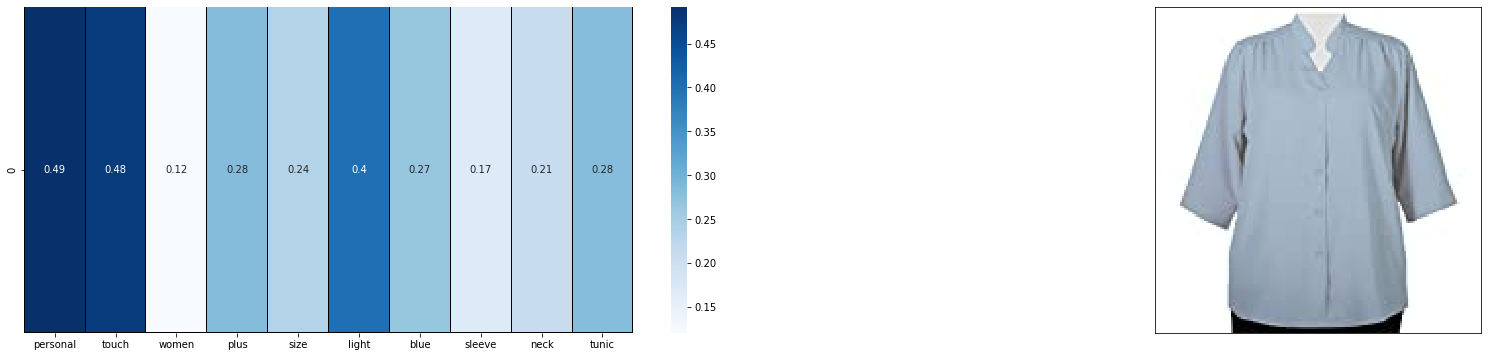

Title :  personal touch women plus size purple neck top
ASIN :  B01LYU5WJ3
Euclidean distance : 2.449489742783178


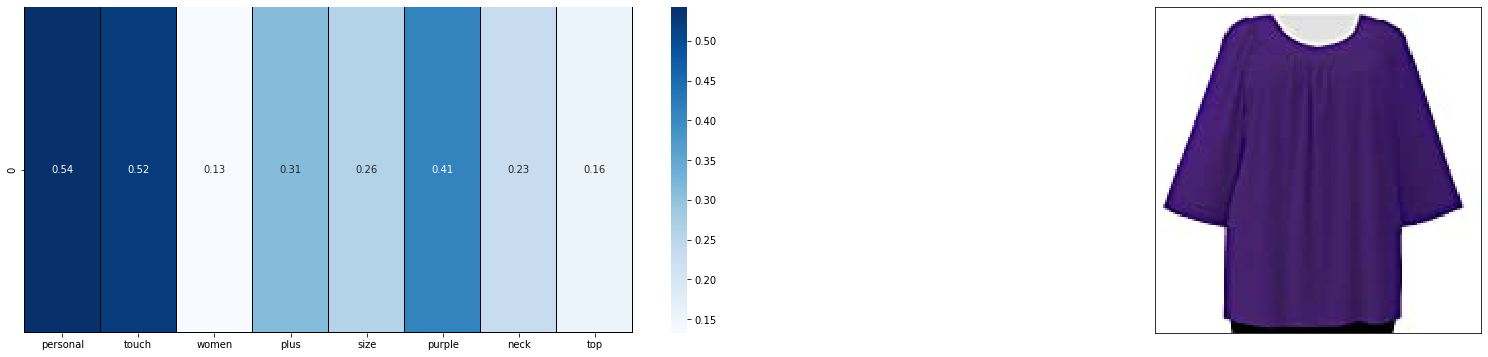

Title :  personal touch blue ikat women plus size top
ASIN :  B06ZZGQ377
Euclidean distance : 2.0


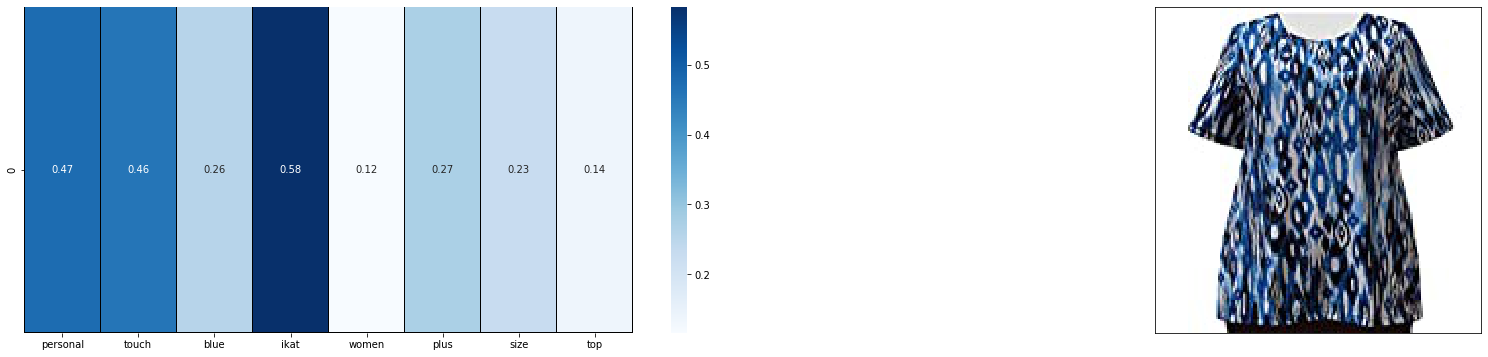

Title :  personal touch women plus size blue white floral blouse shirring
ASIN :  B01DMRYT2M
Euclidean distance : 2.0


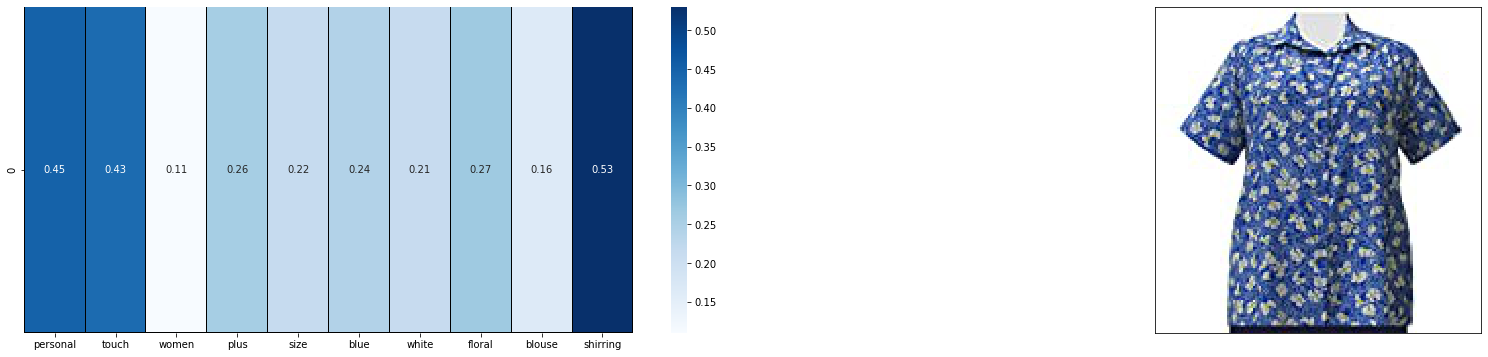

Title :  personal touch multi floral women plus size top
ASIN :  B01NA0FAD6
Euclidean distance : 2.449489742783178


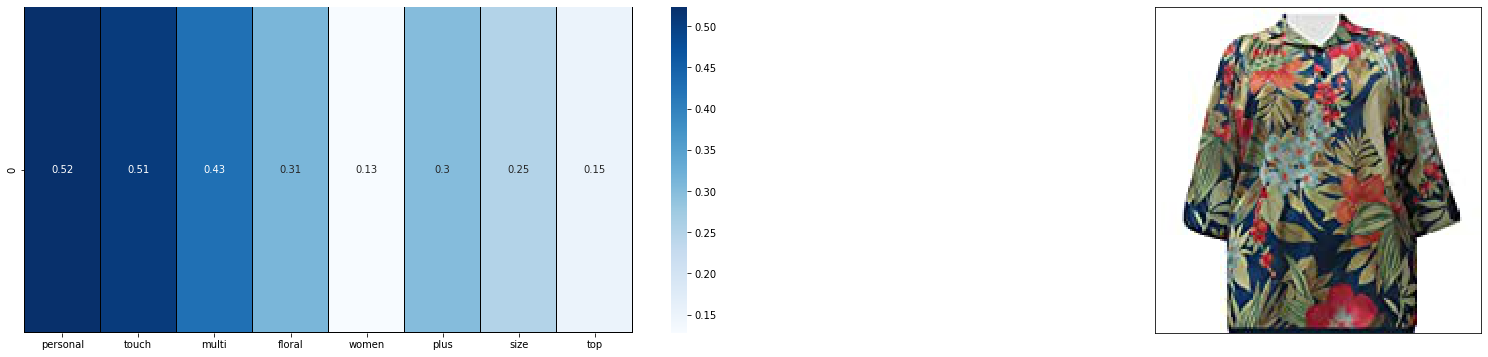

Title :  personal touch women plus size black cotton knit tank top
ASIN :  B01E63KAOC
Euclidean distance : 2.8284271247461903


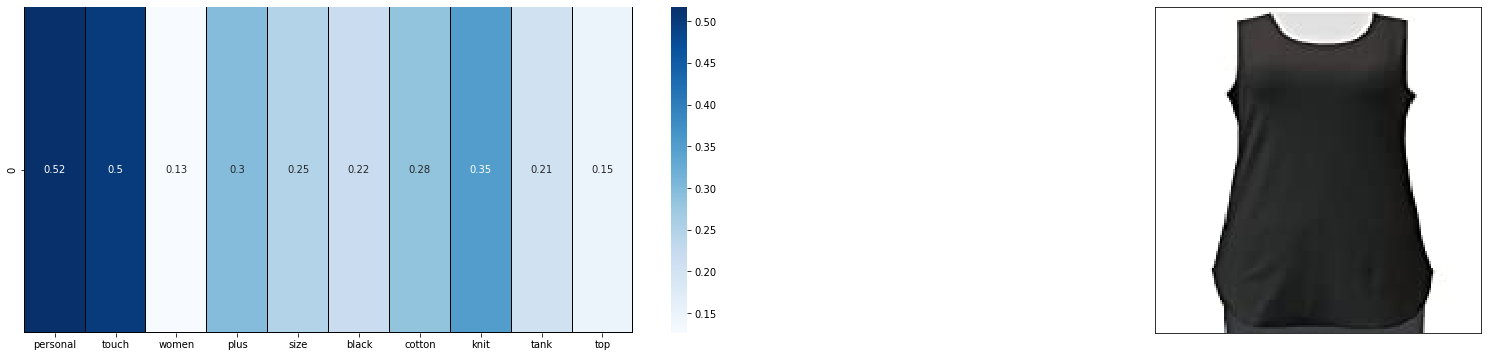

Title :  personal touch women plus size wine tank top
ASIN :  B01LZ5JDHJ
Euclidean distance : 2.449489742783178


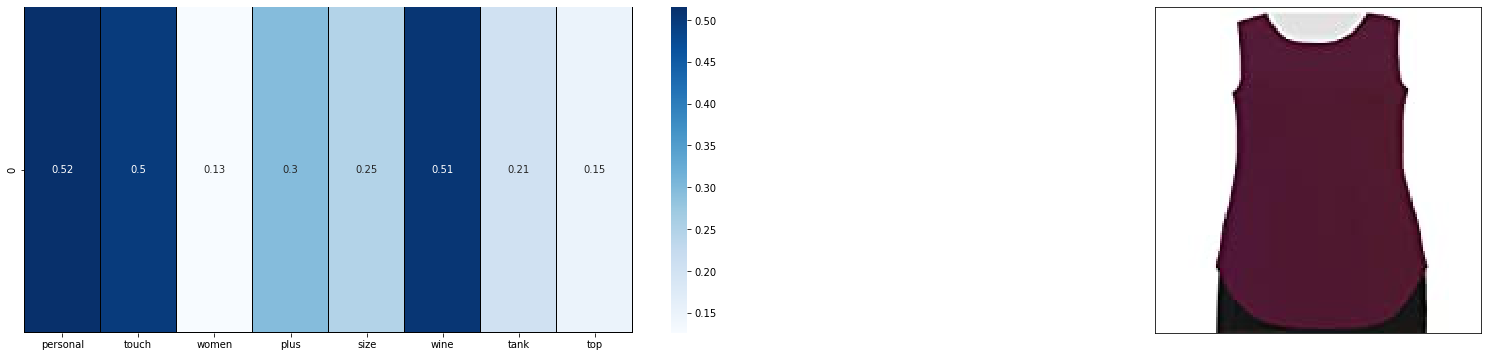

Title :  personal touch leopard lace women plus size top
ASIN :  B01N1A3091
Euclidean distance : 2.449489742783178


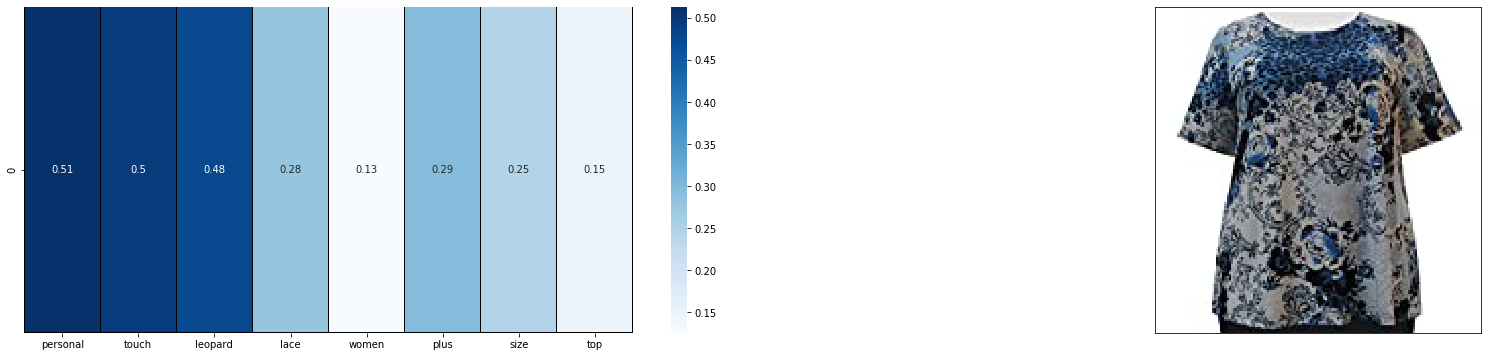

Title :  personal touch women plus size light blue button down tunic
ASIN :  B01HSB1BW4
Euclidean distance : 2.449489742783178


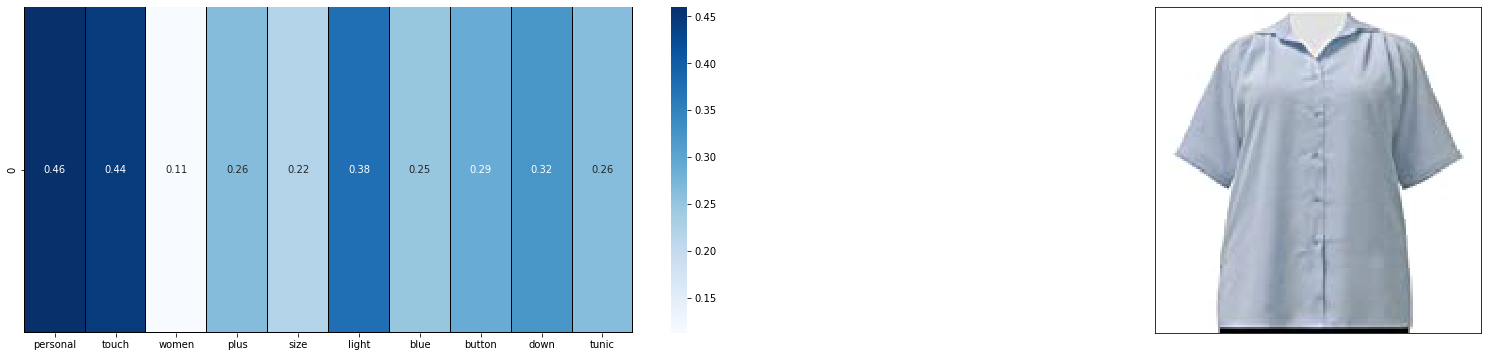

In [32]:
plot_visuals_tfidf(data,vec,451,top=10)

<h1>4. Using K-Means clustering algorithm to display the top products</h1> 
<ol>
    <li>We will use TF-IDF to vectorize the data</li>
    <li>We will visualize data in 2D using T-SNE</li>
    <li>we will perform K-Means on 2D data produced using t-sne to get the cluster in which the point exists</li>
    <li>Then using t-sne 2D data and labels from K-Means to plot scatterplot of the data</li>

In [68]:
#Applying TF-IDF vectorizer on the title
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(data['title'])

In [69]:
#appling t-sne on the vectorized data to produce 2D data
tsne= TSNE(n_components=2).fit_transform(vec)

In [70]:
#Fitting K-means algorithm on t-sne data to get the labels for each data points using 4 clusters
kmeans = KMeans(n_clusters=4,verbose=1)
kmeans.fit_transform(tsne)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 31541410.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 29122106.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 28280920.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 28013608.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 27906796.0
start iteration
done sorting
end inner loop
Iteration 5, inertia 27853856.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 27836296.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 27828324.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 27825258.0
center shift 9.519523e-02 within tolerance 9.857036e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 30418028.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 28777458.0
start iteration
done sorting
end inner loop
Iteration 2, ine

Iteration 5, inertia 28744760.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 28730540.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 28723664.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 28720856.0
center shift 9.230123e-02 within tolerance 9.857036e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 30845370.0
start iteration
done sorting
end inner loop
Iteration 1, inertia 28774436.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 28170846.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 27947888.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 27886976.0
start iteration
done sorting
end inner loop
Iteration 5, inertia 27857578.0
start iteration
done sorting
end inner loop
Iteration 6, inertia 27842550.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 27828526.0
start iteration
done sorting
end inner loop
Iteratio

array([[15.624896, 66.22075 , 38.932808, 56.391098],
       [58.864315, 42.15735 , 10.731313, 70.428246],
       [43.244106, 41.754032, 17.548574, 56.764122],
       ...,
       [20.798819, 94.25604 , 73.99301 , 63.987057],
       [13.148425, 87.2968  , 61.811073, 64.51621 ],
       [ 9.983962, 80.528145, 64.12206 , 51.632946]], dtype=float32)

In [71]:
kmeans.labels_

array([0, 2, 2, ..., 0, 0, 0])

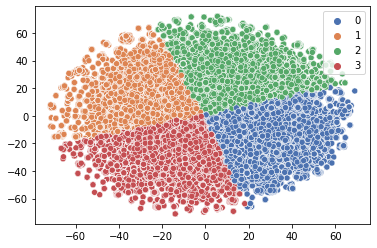

In [73]:
#Using the 2D data produced from T-SNE and labels from K_Means to display scatterplot
dim=[[i[0] for i in tsne],[i[1] for i in tsne],kmeans.labels_]
sns.scatterplot(x=dim[0],y=dim[1],hue=dim[2],palette="deep")

In [74]:
#Creating sparse matrix out of the corpus
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(data['title'])

In [ ]:
#Finding the optimal K-Means
#We will choose the cluster for which the inertia values is the least
inertia=[]

for i in range(1,10):
    Kmeans = KMeans(n_clusters=i)
    kmeans.fit_transform(vec)
    inertia.append((kmeans.inertia_))

Initialization complete
Iteration  0, inertia 88414.565
Iteration  1, inertia 46123.961
Iteration  2, inertia 45989.958
Iteration  3, inertia 45888.889
Iteration  4, inertia 45833.946
Iteration  5, inertia 45800.076
Iteration  6, inertia 45777.346
Iteration  7, inertia 45765.110
Iteration  8, inertia 45761.451
Iteration  9, inertia 45759.730
Iteration 10, inertia 45758.589
Iteration 11, inertia 45758.108
Iteration 12, inertia 45757.933
Iteration 13, inertia 45757.855
Iteration 14, inertia 45757.784
Iteration 15, inertia 45757.715
Iteration 16, inertia 45757.634
Iteration 17, inertia 45757.580
Iteration 18, inertia 45757.551
Iteration 19, inertia 45757.540
Iteration 20, inertia 45757.535
Iteration 21, inertia 45757.533
Iteration 22, inertia 45757.532
Iteration 23, inertia 45757.531
Iteration 24, inertia 45757.530
Converged at iteration 24: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 87510.051
Iteration  1, inertia 45994.937
Itera

Iteration  1, inertia 46107.611
Iteration  2, inertia 46033.668
Iteration  3, inertia 45989.818
Iteration  4, inertia 45882.224
Iteration  5, inertia 45770.427
Iteration  6, inertia 45752.115
Iteration  7, inertia 45750.429
Iteration  8, inertia 45750.143
Iteration  9, inertia 45750.079
Iteration 10, inertia 45750.066
Iteration 11, inertia 45750.063
Iteration 12, inertia 45750.063
Converged at iteration 12: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 89067.929
Iteration  1, inertia 46052.392
Iteration  2, inertia 45878.775
Iteration  3, inertia 45813.724
Iteration  4, inertia 45780.145
Iteration  5, inertia 45765.997
Iteration  6, inertia 45762.025
Iteration  7, inertia 45760.392
Iteration  8, inertia 45758.534
Iteration  9, inertia 45754.959
Iteration 10, inertia 45752.104
Iteration 11, inertia 45751.677
Iteration 12, inertia 45751.634
Iteration 13, inertia 45751.607
Iteration 14, inertia 45751.591
Iteration 15, inertia 45751.5

Iteration 25, inertia 45675.743
Iteration 26, inertia 45675.742
Iteration 27, inertia 45675.741
Iteration 28, inertia 45675.740
Iteration 29, inertia 45675.739
Iteration 30, inertia 45675.738
Iteration 31, inertia 45675.737
Iteration 32, inertia 45675.737
Iteration 33, inertia 45675.736
Iteration 34, inertia 45675.735
Iteration 35, inertia 45675.732
Iteration 36, inertia 45675.730
Iteration 37, inertia 45675.729
Iteration 38, inertia 45675.729
Iteration 39, inertia 45675.726
Iteration 40, inertia 45675.725
Converged at iteration 40: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 89114.894
Iteration  1, inertia 46146.558
Iteration  2, inertia 45864.722
Iteration  3, inertia 45779.488
Iteration  4, inertia 45757.616
Iteration  5, inertia 45747.274
Iteration  6, inertia 45741.001
Iteration  7, inertia 45733.614
Iteration  8, inertia 45732.648
Iteration  9, inertia 45732.529
Iteration 10, inertia 45732.491
Iteration 11, inertia 45732.4

Iteration  0, inertia 89693.163
Iteration  1, inertia 46022.064
Iteration  2, inertia 45834.297
Iteration  3, inertia 45740.541
Iteration  4, inertia 45686.664
Iteration  5, inertia 45665.445
Iteration  6, inertia 45660.561
Iteration  7, inertia 45659.145
Iteration  8, inertia 45658.362
Iteration  9, inertia 45658.075
Iteration 10, inertia 45657.990
Iteration 11, inertia 45657.961
Iteration 12, inertia 45657.950
Iteration 13, inertia 45657.941
Iteration 14, inertia 45657.936
Iteration 15, inertia 45657.935
Iteration 16, inertia 45657.935
Converged at iteration 16: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 87650.676
Iteration  1, inertia 46051.454
Iteration  2, inertia 46002.940
Iteration  3, inertia 45985.033
Iteration  4, inertia 45958.057
Iteration  5, inertia 45895.282
Iteration  6, inertia 45773.975
Iteration  7, inertia 45711.151
Iteration  8, inertia 45697.892
Iteration  9, inertia 45691.595
Iteration 10, inertia 45687.9

Iteration 13, inertia 45699.085
Iteration 14, inertia 45699.084
Iteration 15, inertia 45699.084
Converged at iteration 15: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 87344.546
Iteration  1, inertia 46146.243
Iteration  2, inertia 45973.664
Iteration  3, inertia 45919.221
Iteration  4, inertia 45889.300
Iteration  5, inertia 45858.495
Iteration  6, inertia 45826.848
Iteration  7, inertia 45803.255
Iteration  8, inertia 45788.572
Iteration  9, inertia 45781.995
Iteration 10, inertia 45780.835
Iteration 11, inertia 45780.505
Iteration 12, inertia 45780.385
Iteration 13, inertia 45780.348
Iteration 14, inertia 45780.335
Iteration 15, inertia 45780.328
Iteration 16, inertia 45780.326
Iteration 17, inertia 45780.326
Iteration 18, inertia 45780.325
Converged at iteration 18: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 90343.220
Iteration  1, inertia 46133.653
Iteration  2, iner

Iteration 12, inertia 45709.023
Iteration 13, inertia 45708.277
Iteration 14, inertia 45707.417
Iteration 15, inertia 45706.401
Iteration 16, inertia 45705.240
Iteration 17, inertia 45704.258
Iteration 18, inertia 45703.658
Iteration 19, inertia 45703.360
Iteration 20, inertia 45703.194
Iteration 21, inertia 45703.075
Iteration 22, inertia 45703.009
Iteration 23, inertia 45702.965
Iteration 24, inertia 45702.903
Iteration 25, inertia 45702.856
Iteration 26, inertia 45702.838
Iteration 27, inertia 45702.826
Iteration 28, inertia 45702.822
Iteration 29, inertia 45702.821
Iteration 30, inertia 45702.820
Iteration 31, inertia 45702.820
Iteration 32, inertia 45702.820
Iteration 33, inertia 45702.820
Iteration 34, inertia 45702.819
Iteration 35, inertia 45702.819
Iteration 36, inertia 45702.818
Iteration 37, inertia 45702.818
Iteration 38, inertia 45702.818
Iteration 39, inertia 45702.817
Iteration 40, inertia 45702.817
Iteration 41, inertia 45702.817
Converged at iteration 41: center shift 

Iteration 15, inertia 45674.220
Iteration 16, inertia 45674.219
Iteration 17, inertia 45674.219
Iteration 18, inertia 45674.219
Iteration 19, inertia 45674.219
Iteration 20, inertia 45674.218
Converged at iteration 20: center shift 0.000000e+00 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 89135.101
Iteration  1, inertia 46066.966
Iteration  2, inertia 45867.566
Iteration  3, inertia 45764.117
Iteration  4, inertia 45722.928
Iteration  5, inertia 45703.026
Iteration  6, inertia 45691.937
Iteration  7, inertia 45685.034
Iteration  8, inertia 45680.385
Iteration  9, inertia 45677.100
Iteration 10, inertia 45674.386
Iteration 11, inertia 45672.128
Iteration 12, inertia 45671.004
Iteration 13, inertia 45670.529
Iteration 14, inertia 45670.221
Iteration 15, inertia 45670.040
Iteration 16, inertia 45669.951
Iteration 17, inertia 45669.917
Iteration 18, inertia 45669.903
Iteration 19, inertia 45669.898
Iteration 20, inertia 45669.897
Converged at iteration 20: ce

Iteration  4, inertia 45745.247
Iteration  5, inertia 45714.853
Iteration  6, inertia 45702.431
Iteration  7, inertia 45696.240
Iteration  8, inertia 45692.421
Iteration  9, inertia 45689.341
Iteration 10, inertia 45686.158
Iteration 11, inertia 45682.197
Iteration 12, inertia 45678.015
Iteration 13, inertia 45674.572
Iteration 14, inertia 45672.081
Iteration 15, inertia 45670.898
Iteration 16, inertia 45670.372
Iteration 17, inertia 45670.139
Iteration 18, inertia 45670.029
Iteration 19, inertia 45669.968
Iteration 20, inertia 45669.932
Iteration 21, inertia 45669.913
Iteration 22, inertia 45669.903
Iteration 23, inertia 45669.898
Iteration 24, inertia 45669.898
Converged at iteration 24: center shift 5.486867e-09 within tolerance 5.556661e-09
Initialization complete
Iteration  0, inertia 88738.282
Iteration  1, inertia 46142.052
Iteration  2, inertia 45991.693


In [ ]:
inertia 

In [ ]:
#Scaling inertia values to 0-1
inertia = [i/max(inertia) for i in inertia]

In [ ]:
#Plotting the graph of n_clusters vs inertia
plt.plot([i for i in range(1,10)],inertia)

<h3>Conclusion : For 7 clusters we get least inertia, hence we will use 7 clusters to fit K-Means algorithm

In [35]:
#using 7 as number of clusters and running the KMeans algorithm
kmeans = KMeans(n_clusters=7)
kmeans.fit_transform(vec)

array([[0.99140448, 0.98580667, 1.02703907, ..., 1.02362238, 1.05190025,
        1.00577035],
       [1.00969719, 0.9979549 , 1.04445504, ..., 1.05579166, 1.08090148,
        1.01761509],
       [1.00689806, 1.00406769, 1.04595185, ..., 1.06578647, 1.08825288,
        1.016754  ],
       ...,
       [0.98619491, 0.99054893, 1.02571033, ..., 0.98489731, 1.05252426,
        1.01436215],
       [0.95863353, 0.97441834, 0.99408445, ..., 0.92760618, 1.02105137,
        0.99563119],
       [0.97912215, 0.9743826 , 1.00482029, ..., 0.87871835, 0.99183758,
        1.00848275]])

In [36]:
kmeans.labels_

array([1, 1, 1, ..., 4, 4, 4])

In [37]:
#Adding labels columns in our dataset
#The labels define in which cluster a particular point belongs to
data['labels']=kmeans.labels_

In [38]:
data.sample(10)

,asin,product_type_name,color,brand,medium_image_url,title,labels
12200,B01MYPAP2W,SHIRT,Red,The Workout Princess,https://images-na.ssl-images-amazon.com/images...,elf you off shoulder tacky christmas sweater,0
16224,B06XR9BK5W,SHIRT,Red,Grace Silk,https://images-na.ssl-images-amazon.com/images...,grace silk solid color long sleeve satin silk ...,0
16382,B073Z6B9JJ,SHIRT,White,GuPoBoU168,https://images-na.ssl-images-amazon.com/images...,gupobou fashion classic women unicorn printed ...,1
28745,B01BFLT6W0,BOOKS_1973_AND_LATER,Red,Scarface,https://images-na.ssl-images-amazon.com/images...,officially licensed merchandise the world is y...,1
39706,B00LUYY6SC,SHIRT,White,FIFA,https://images-na.ssl-images-amazon.com/images...,usa soccer juniors tank top,6
16691,B017UQSSLE,SHIRT,Black,Ripleys Clothing,https://images-na.ssl-images-amazon.com/images...,hell bunny woodland hermeline apron pinny flow...,1
28534,B06VT38GVR,SHIRT,As Same Pirture,Obazidou,https://images-na.ssl-images-amazon.com/images...,obazidou women neck feather print shirt casual...,4
43675,B01MQU13AH,OUTERWEAR,White,MChoice,https://images-na.ssl-images-amazon.com/images...,women blouse mchoice women striped long sleeve...,4
19957,B014SMF3KC,SHIRT,White,Jayayamala,https://images-na.ssl-images-amazon.com/images...,jayayamala white tunic women’s clothing plus s...,2
30289,B06XYGWTM7,SHIRT,*,Cheapasstees,https://images-na.ssl-images-amazon.com/images...,pisces horoscope womens shirts,1


In [39]:
#Priting the total number of points belonging to each cluster
data['labels'].value_counts()

1    14573
0    12431
6     5870
3     5403
4     4601
2     2762
5     1846
Name: labels, dtype: int64

In [40]:
#Mapping the datapoints with their closest cluster
#The mapping variable holds the ID in their respective cluster
#Stored value will looks like {0:[5,8,9,6,...],1:[89,56,78,15,..],....}
#The key will be the cluster name and values are the points that belong that cluster
mapping={}

for i in range(0,7):
    
    mapping[i]=data[data['labels']==i].index.tolist()

In [52]:
#Saving the cluster centers
cluster_centroids = kmeans.cluster_centers_

#This method will calculate the top recommended product Id
def top_fashion_KMeans(vec,id,top=5):
    
    query_pt = vec[id]
    nearest_centroid = np.argmin(euclidean_distances(query_pt,cluster_centroids))
    vec1 = vec[mapping[nearest_centroid]]
    
    euc_dist = euclidean_distances(vec[id],vec1[:])
    top_products = np.argsort(euc_dist.reshape(1,-1))[0][0:top+1]
    
    top_fashion = [mapping[nearest_centroid][i] for i in top_products]
    
    print(top_fashion)
    
    return top_fashion


<h1>5. Displaying top products using </h1>
<ul>
    <li>TF-IDF</li>
    <li>KMeans</li>
    <li>BOW</li>
</ul>    

Title :  burnt umber tiger shirt with zebra stripes xl
ASIN :  B00JXQB7IQ
Euclidean distance : 0.0


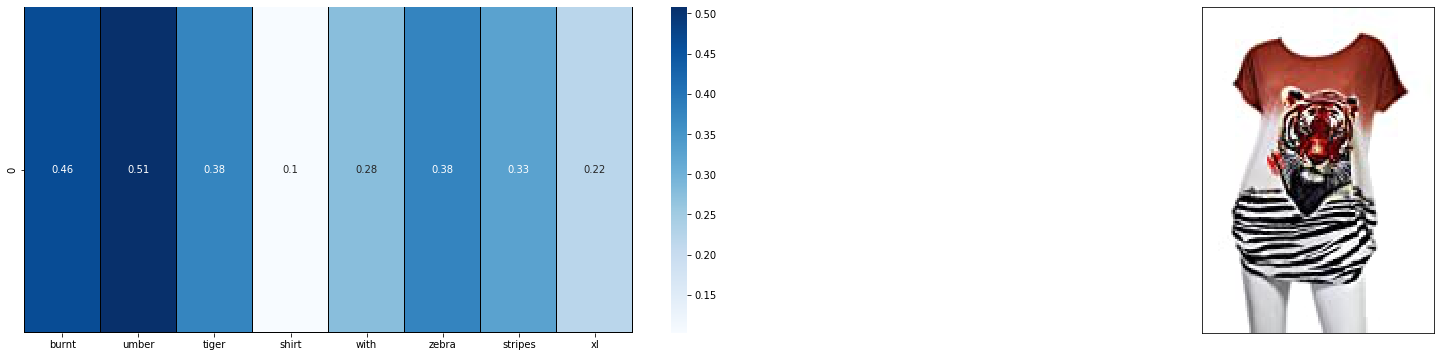

Title :  blue tiger shirt with zebra stripes xl
ASIN :  B00JXQANA4
Euclidean distance : 1.7320508075688772


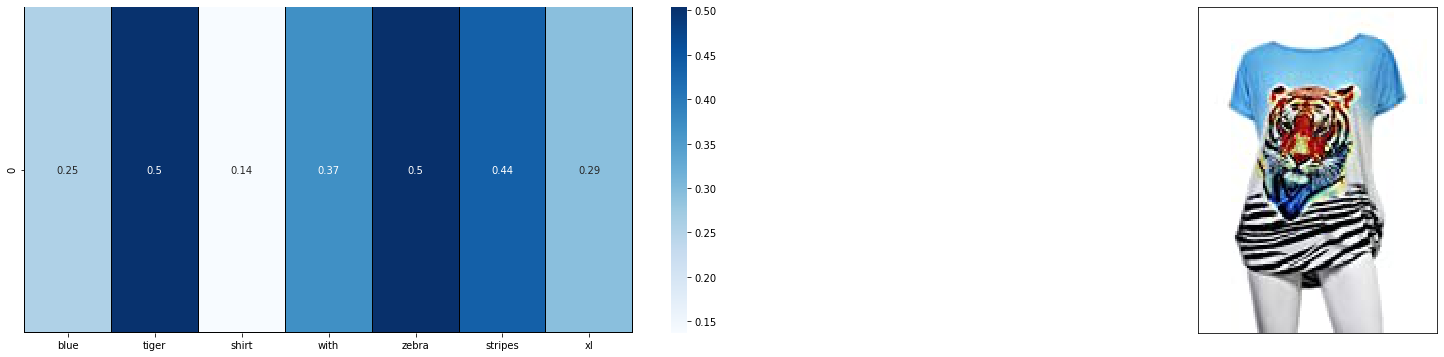

Title :  pink tiger shirt with zebra stripes xl
ASIN :  B00JXQAVN8
Euclidean distance : 1.7320508075688772


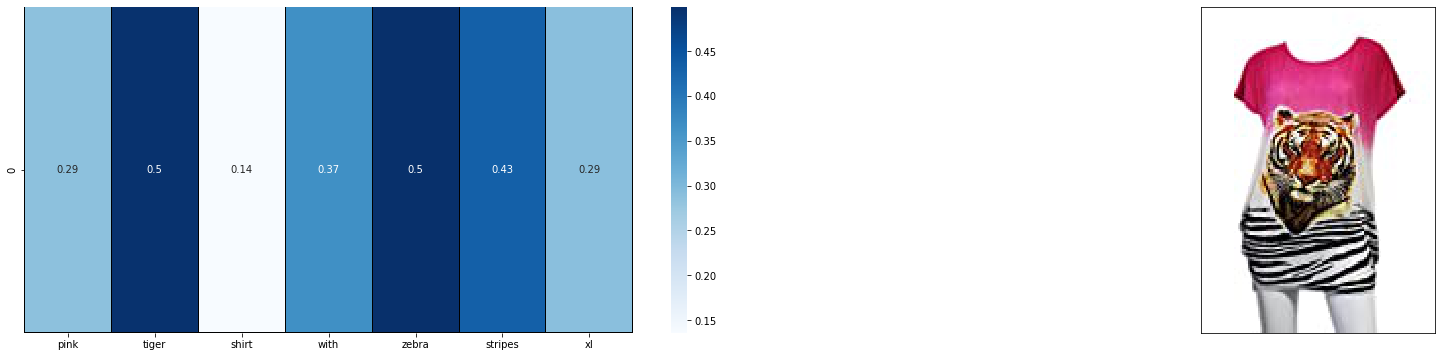

Title :  grey white tiger shirt with tiger stripes xl
ASIN :  B00JXQA8D6
Euclidean distance : 2.449489742783178


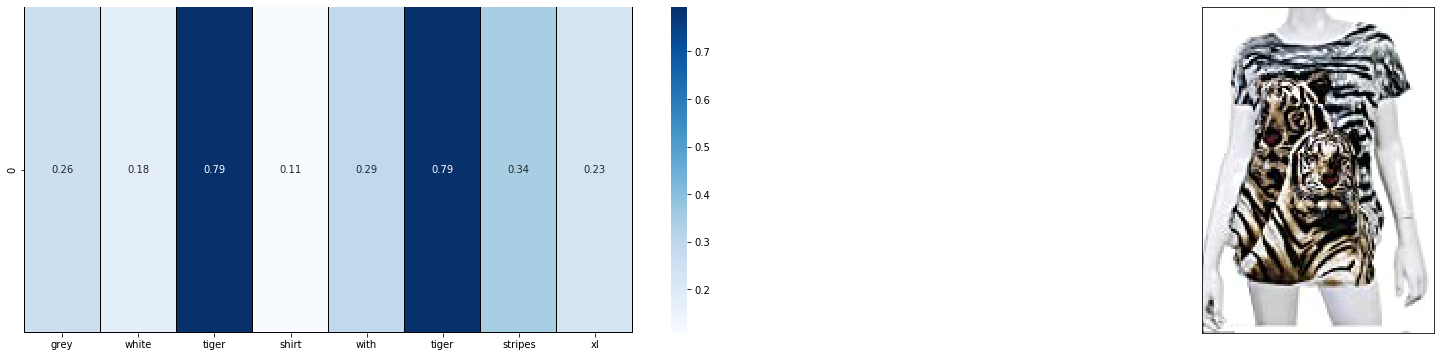

Title :  yellow tiger shirt with tiger stripes xl
ASIN :  B00JXQCS52
Euclidean distance : 2.23606797749979


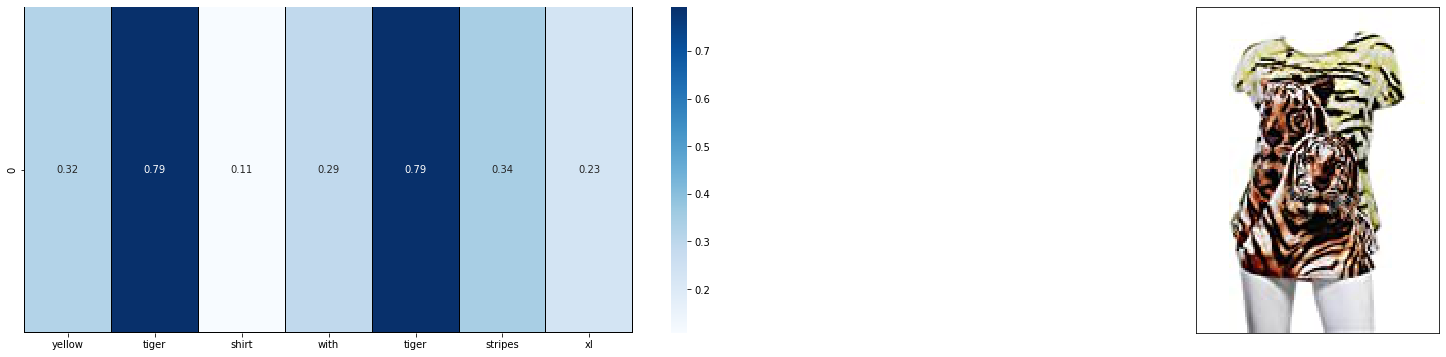

Title :  brown white tiger shirt with tiger stripes xl
ASIN :  B00JXQCZO6
Euclidean distance : 2.449489742783178


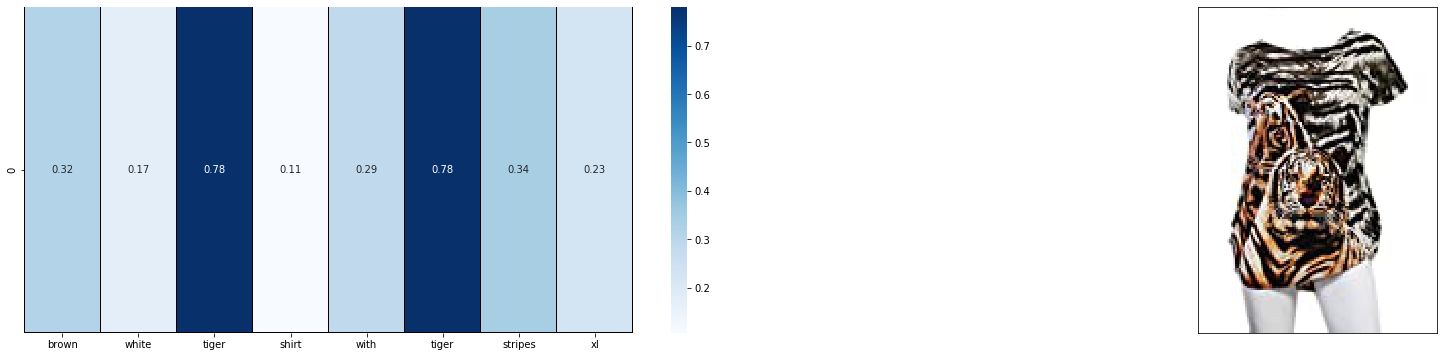

Title :  black white tiger shirt with tiger stripes xl xxl
ASIN :  B00JXQAC2I
Euclidean distance : 2.6457513110645907


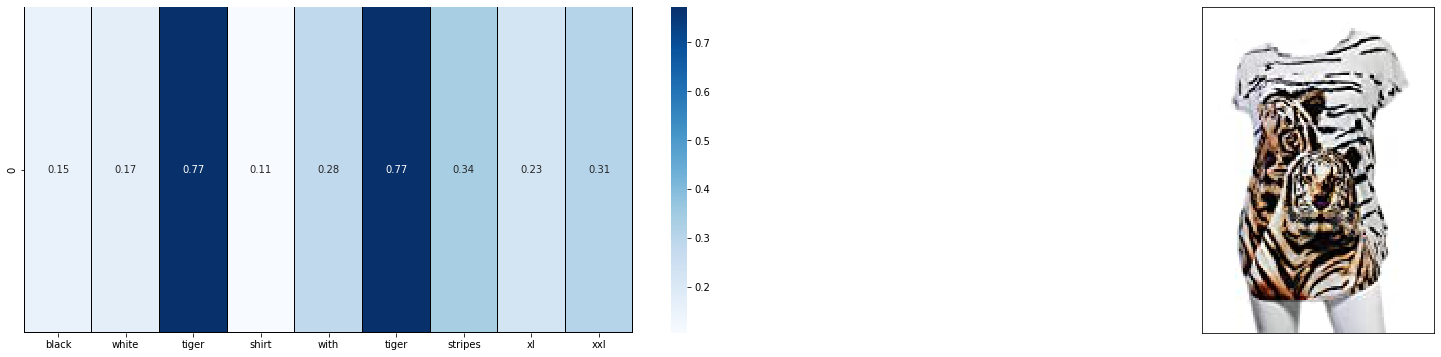

Title :  black white tiger tank top with tiger stripes
ASIN :  B00JXQAO94
Euclidean distance : 3.1622776601683795


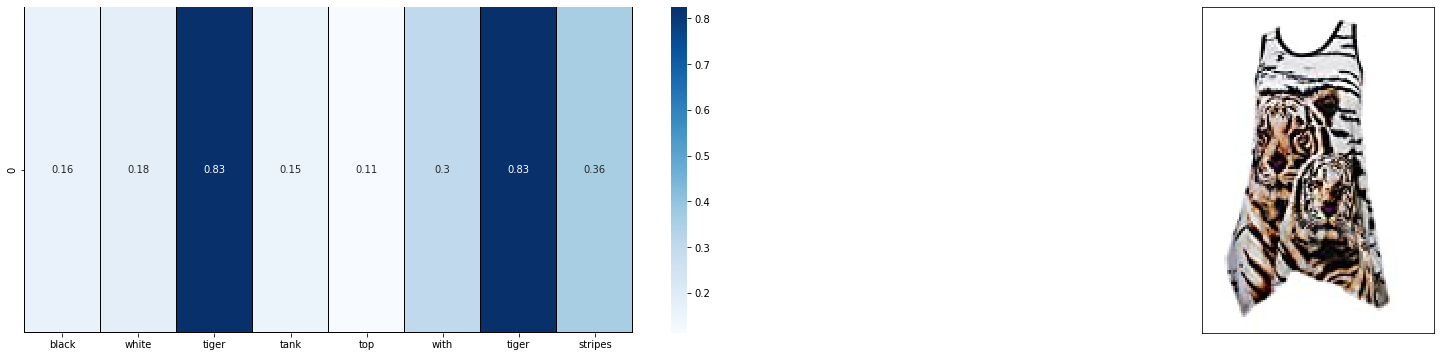

Title :  yellow tiger tank top with tiger stripes
ASIN :  B00JXQAUWA
Euclidean distance : 3.0


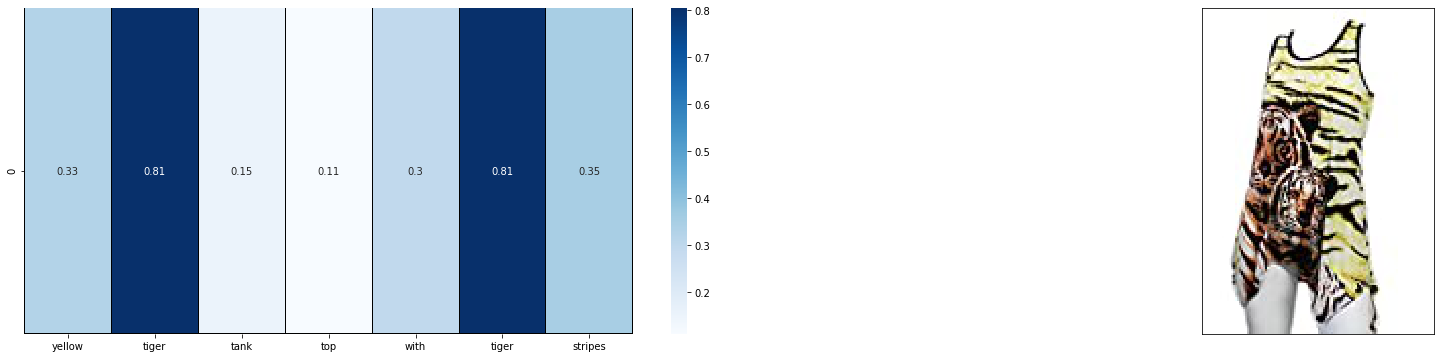

Title :  burnt orange lace bottom tank top
ASIN :  B01AMKZQ7E
Euclidean distance : 3.4641016151377544


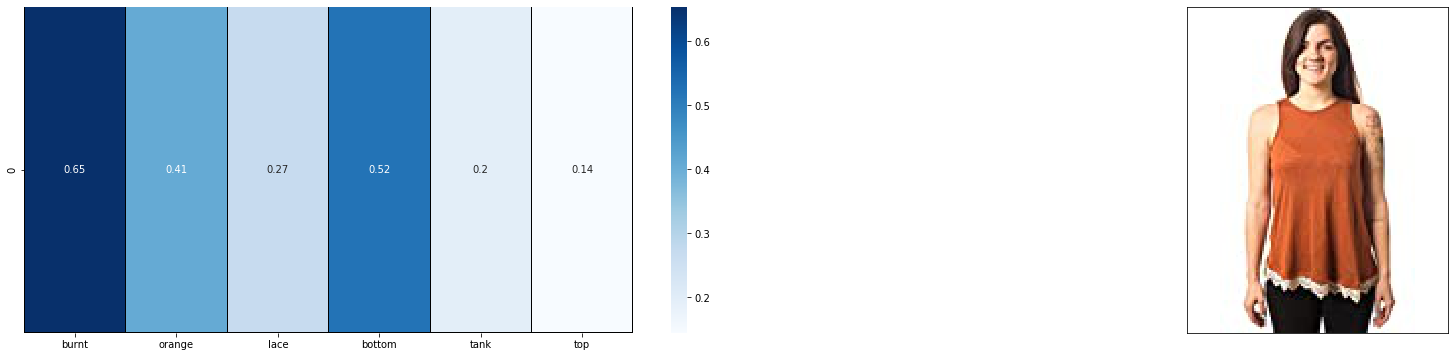

Title :  flowers romance off the shoulder top umber
ASIN :  B01M8PLOYT
Euclidean distance : 3.605551275463989


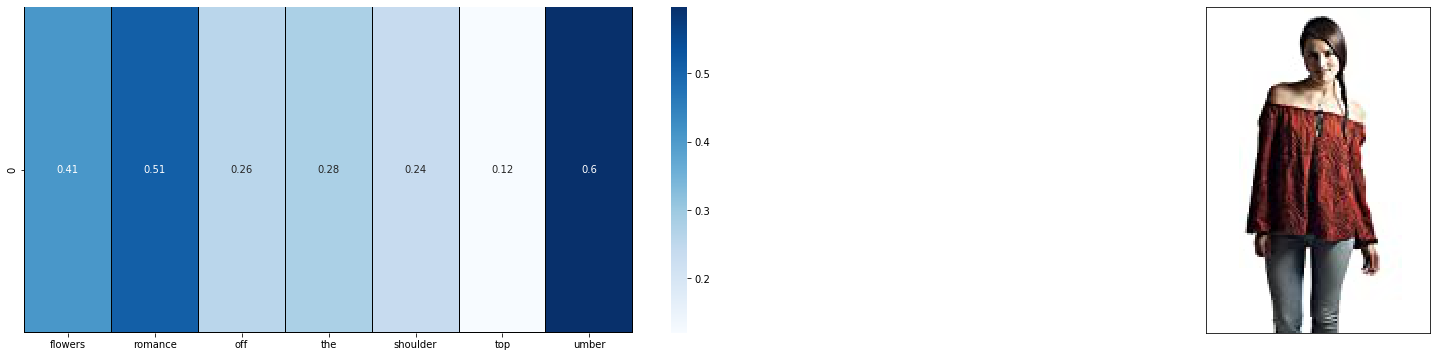

In [48]:
#Top producuts using tf-idf method
plot_visuals_tfidf(data,vec,6288,top=10,model='tf-idf')

[6288, 5483, 30244, 16336, 46265, 6109, 15320, 46786, 46784, 46785, 21509]
Title :  burnt umber tiger shirt with zebra stripes xl
ASIN :  B00JXQB7IQ
Euclidean distance : 0.0


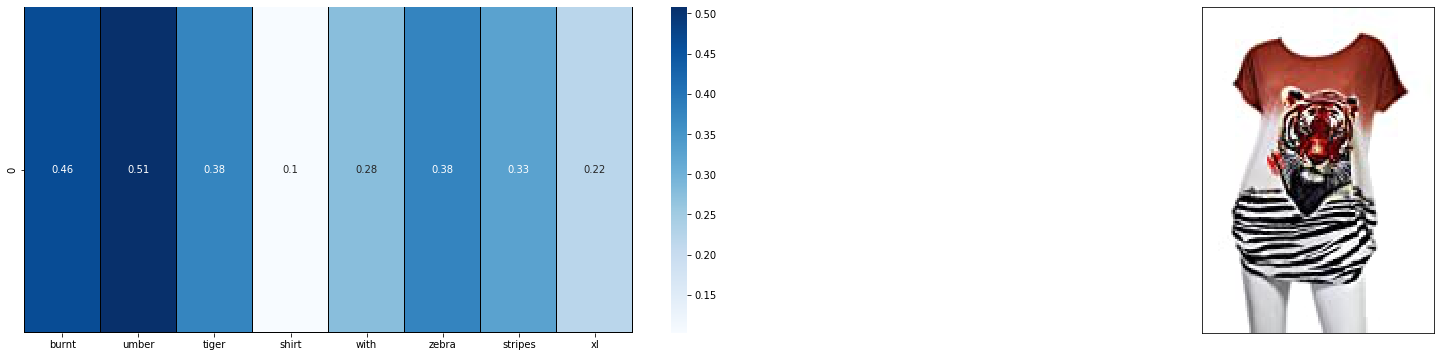

Title :  blue tiger shirt with zebra stripes xl
ASIN :  B00JXQANA4
Euclidean distance : 1.7320508075688772


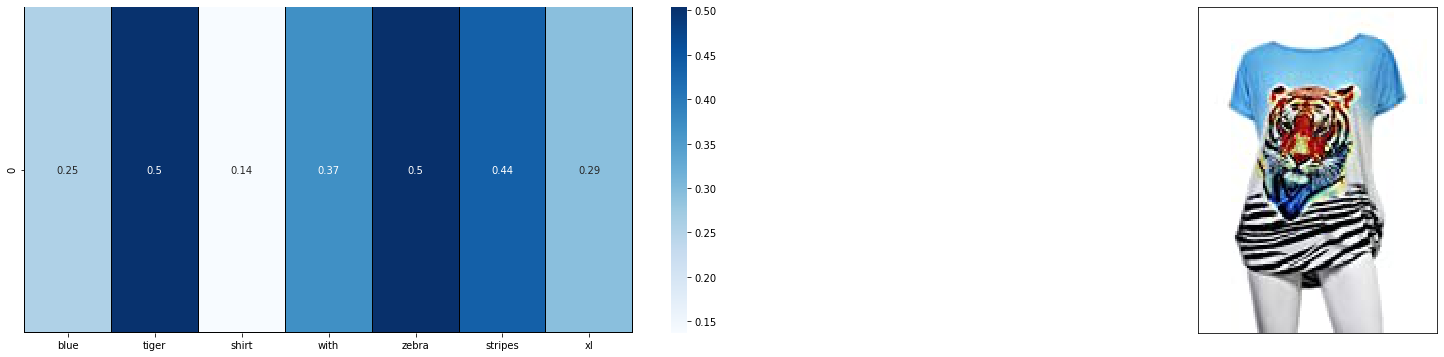

Title :  pink tiger shirt with zebra stripes xl
ASIN :  B00JXQAVN8
Euclidean distance : 1.7320508075688772


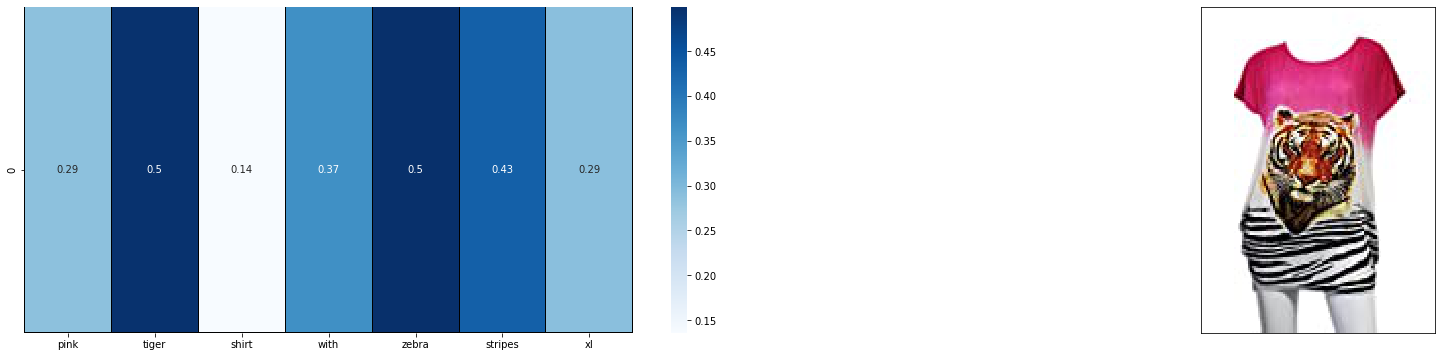

Title :  grey white tiger shirt with tiger stripes xl
ASIN :  B00JXQA8D6
Euclidean distance : 2.449489742783178


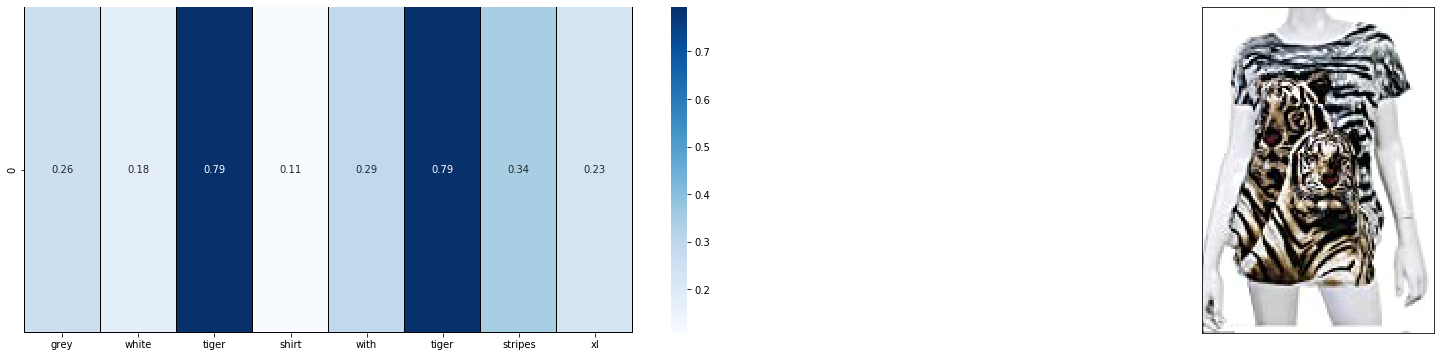

Title :  yellow tiger shirt with tiger stripes xl
ASIN :  B00JXQCS52
Euclidean distance : 2.23606797749979


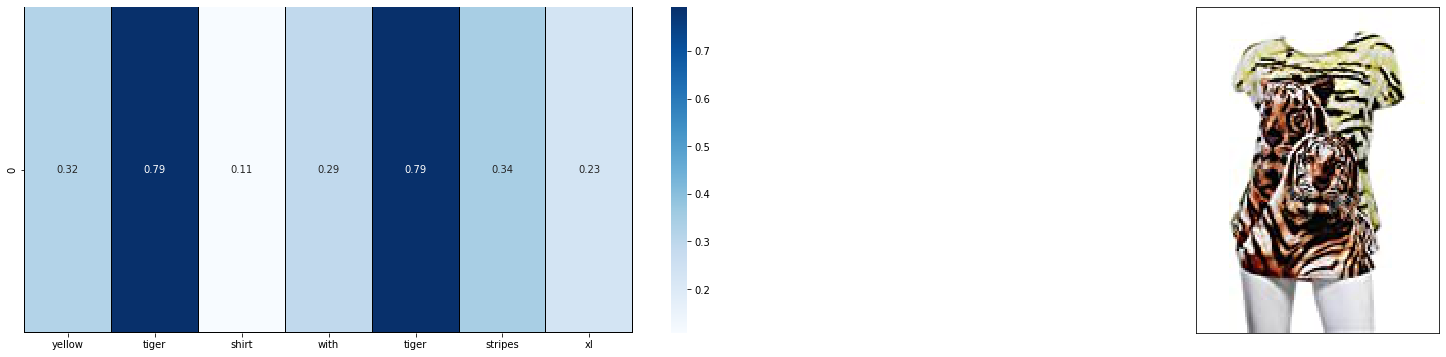

Title :  brown white tiger shirt with tiger stripes xl
ASIN :  B00JXQCZO6
Euclidean distance : 2.449489742783178


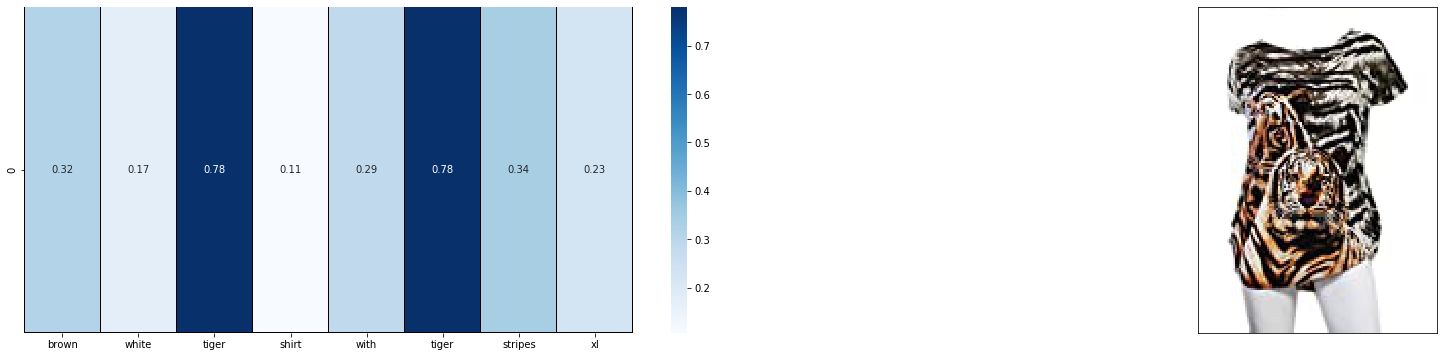

Title :  gant women women long sleeve shirt with stripes
ASIN :  B073QR37QY
Euclidean distance : 3.4641016151377544


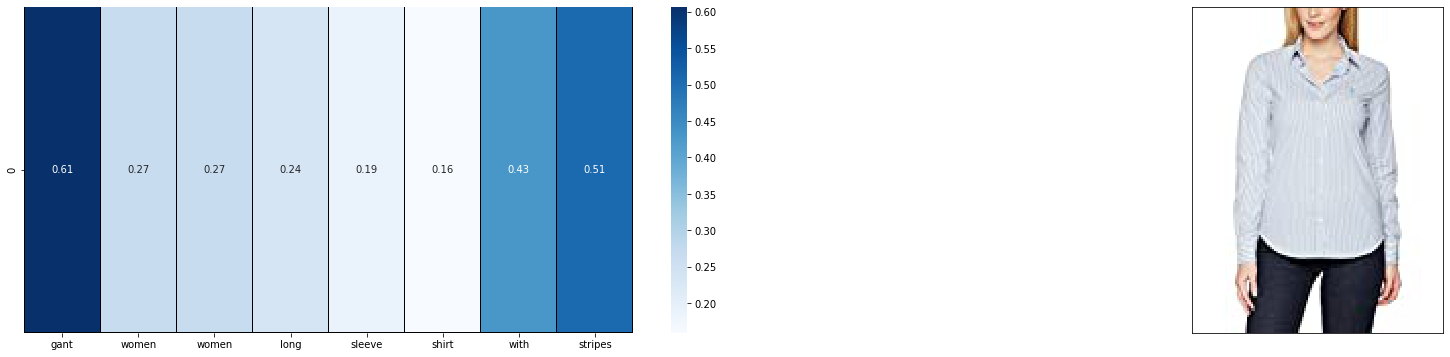

Title :  zebra wild animals women shirt xl new
ASIN :  B01N3SZB62
Euclidean distance : 3.0


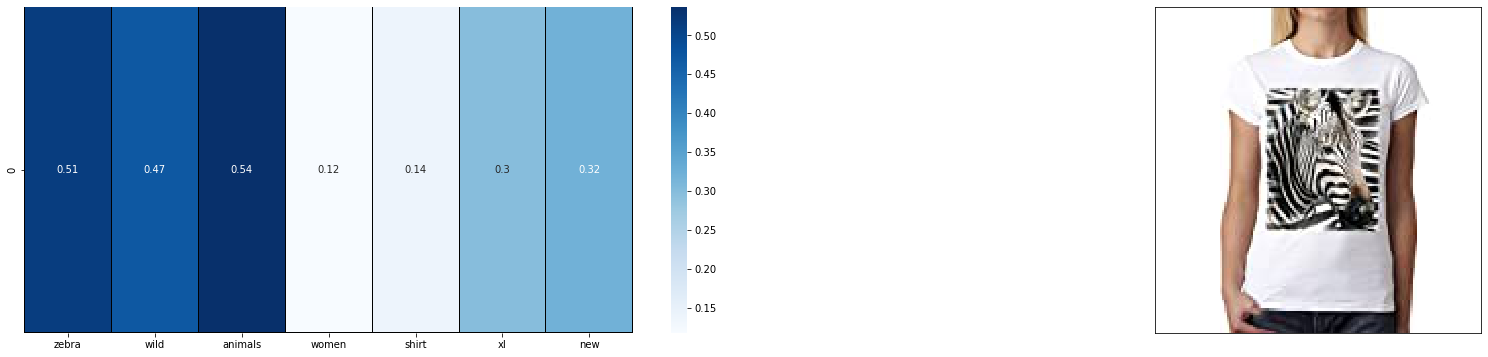

Title :  zebra print women cotton blend shirt
ASIN :  B074XK4L4K
Euclidean distance : 3.1622776601683795


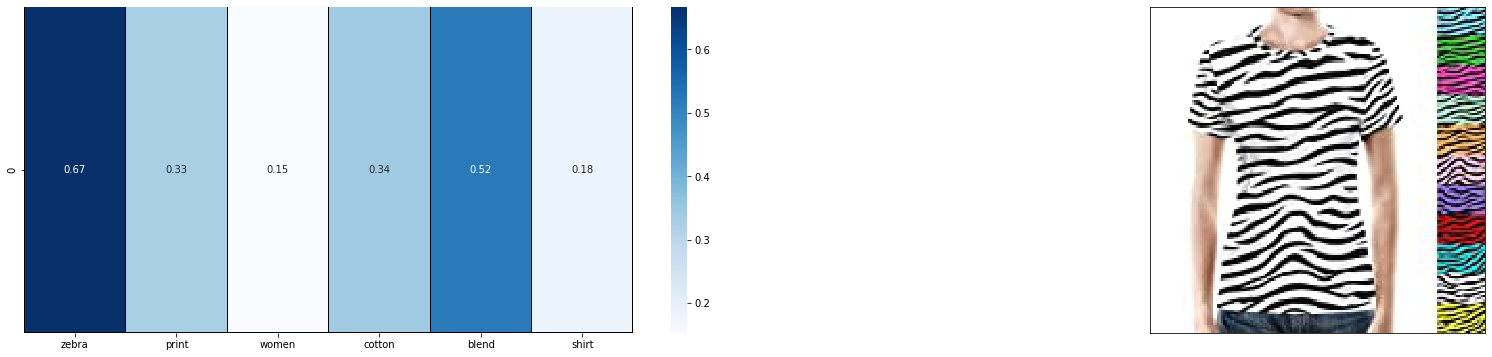

Title :  zebra print women sport mesh shirt
ASIN :  B074X7B1KY
Euclidean distance : 3.1622776601683795


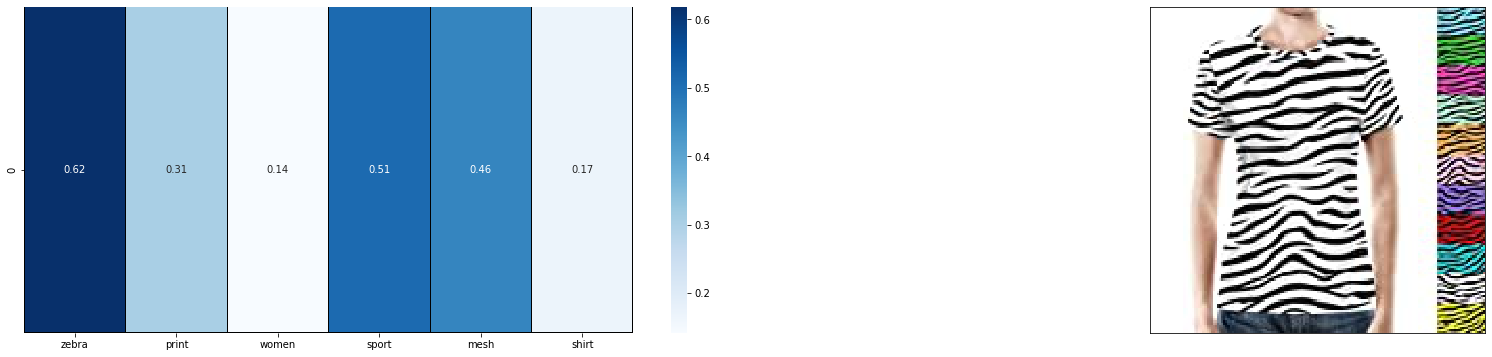

Title :  kenzo women white tiger shirt
ASIN :  B0725YNBG1
Euclidean distance : 3.0


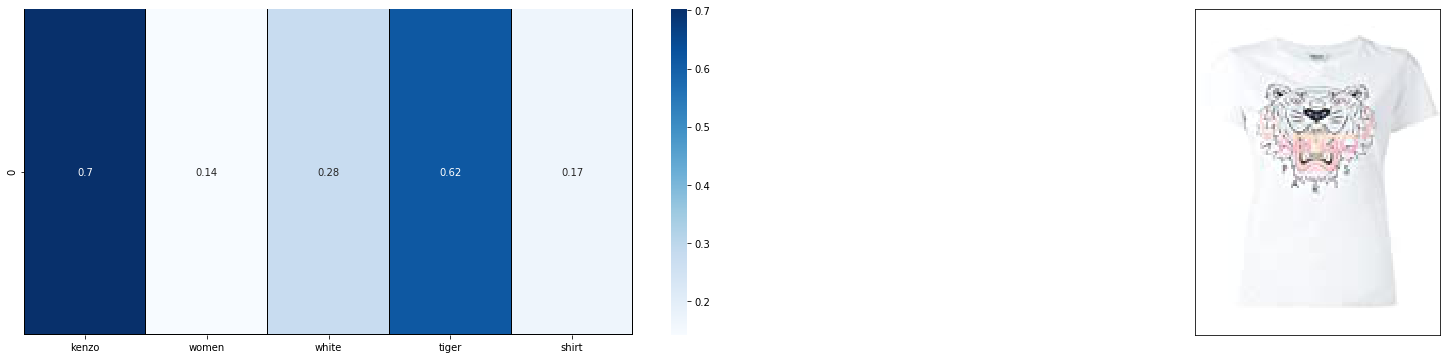

In [54]:
#Top products using KMeans
#NOTE : THIS METHOD REQUIRE YOU TO CALCULATE cluster_centroids before calling this method
plot_visuals_tfidf(data,vec,6288,top=10,model='KMeans')

Title :  burnt umber tiger shirt with zebra stripes xl
ASIN :  B00JXQB7IQ
Euclidean distance :  0.0


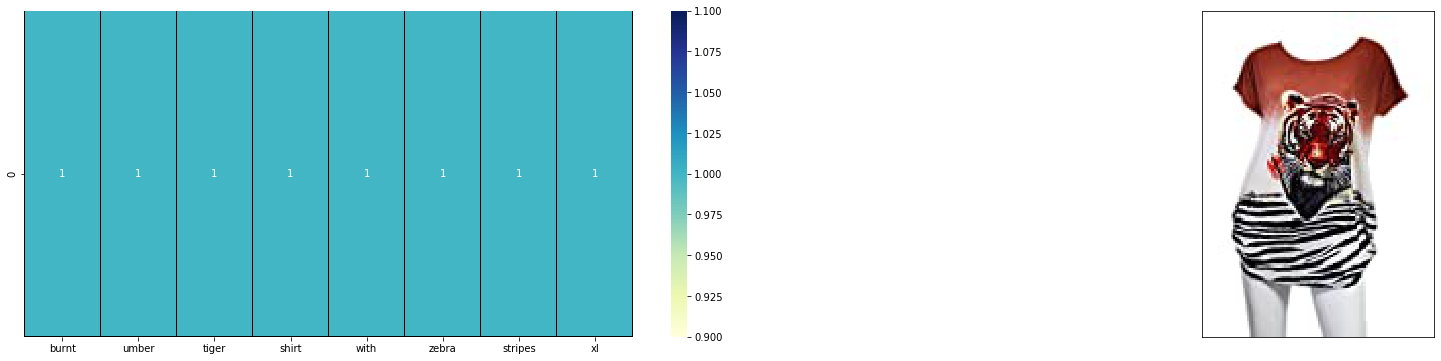

Title :  pink tiger shirt with zebra stripes xl
ASIN :  B00JXQAVN8
Euclidean distance :  1.7320508075688772


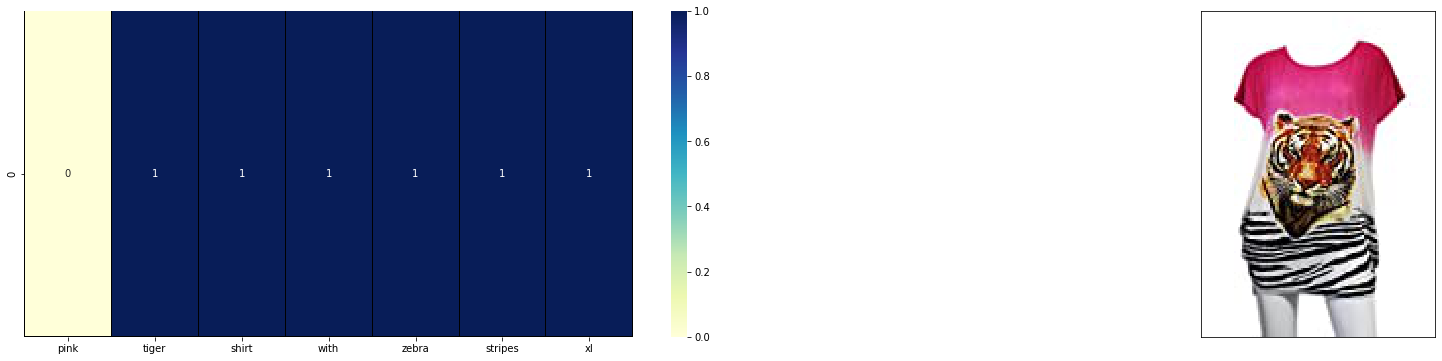

Title :  blue tiger shirt with zebra stripes xl
ASIN :  B00JXQANA4
Euclidean distance :  1.7320508075688772


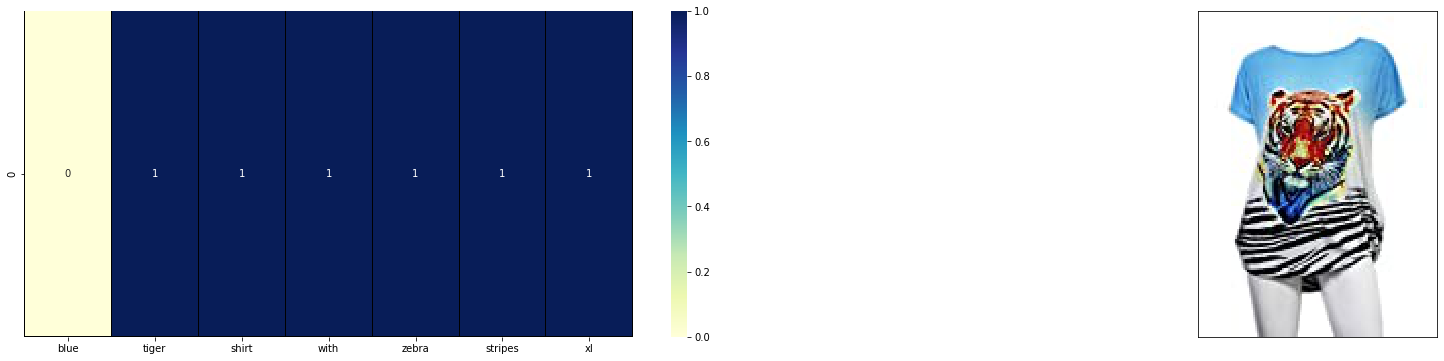

Title :  yellow tiger shirt with tiger stripes xl
ASIN :  B00JXQCS52
Euclidean distance :  2.23606797749979


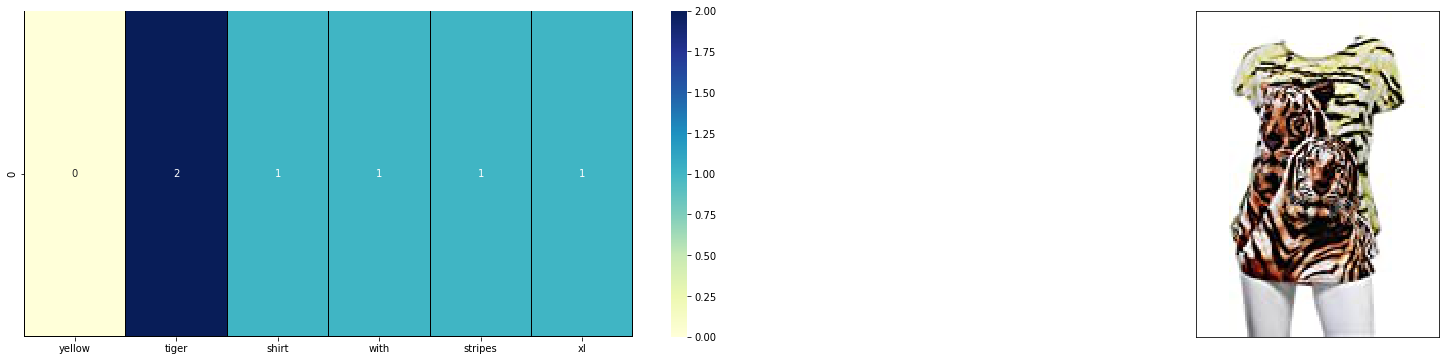

Title :  brown white tiger shirt with tiger stripes xl
ASIN :  B00JXQCZO6
Euclidean distance :  2.449489742783178


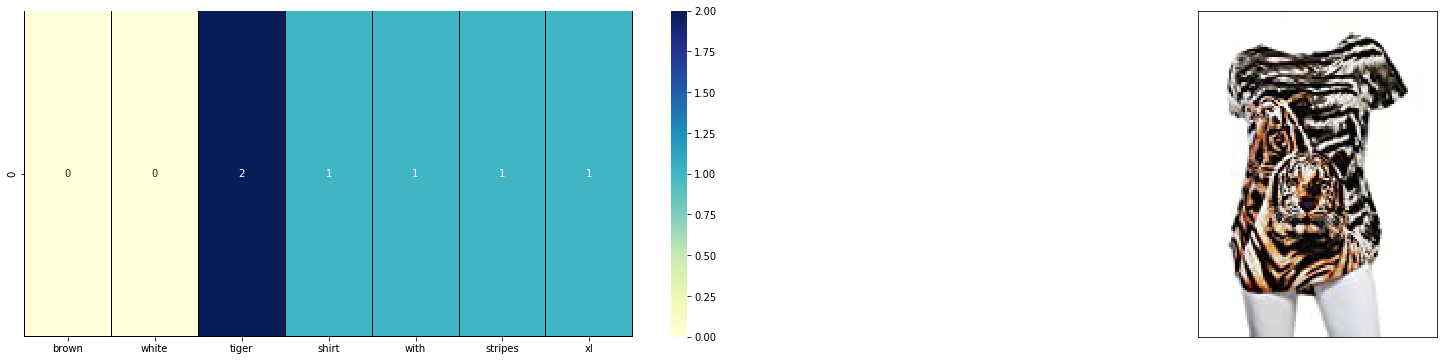

Title :  grey white tiger shirt with tiger stripes xl
ASIN :  B00JXQA8D6
Euclidean distance :  2.449489742783178


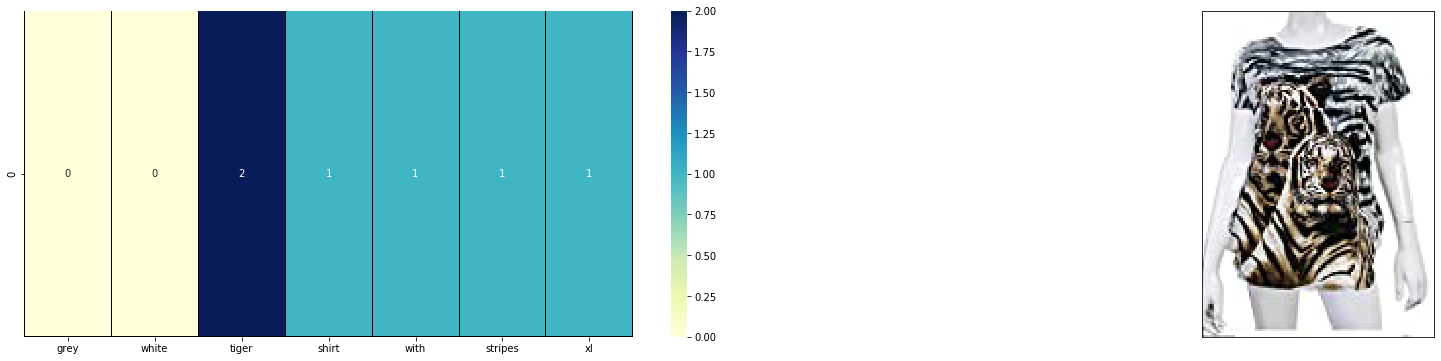

Title :  black white tiger shirt with tiger stripes xl xxl
ASIN :  B00JXQAC2I
Euclidean distance :  2.6457513110645907


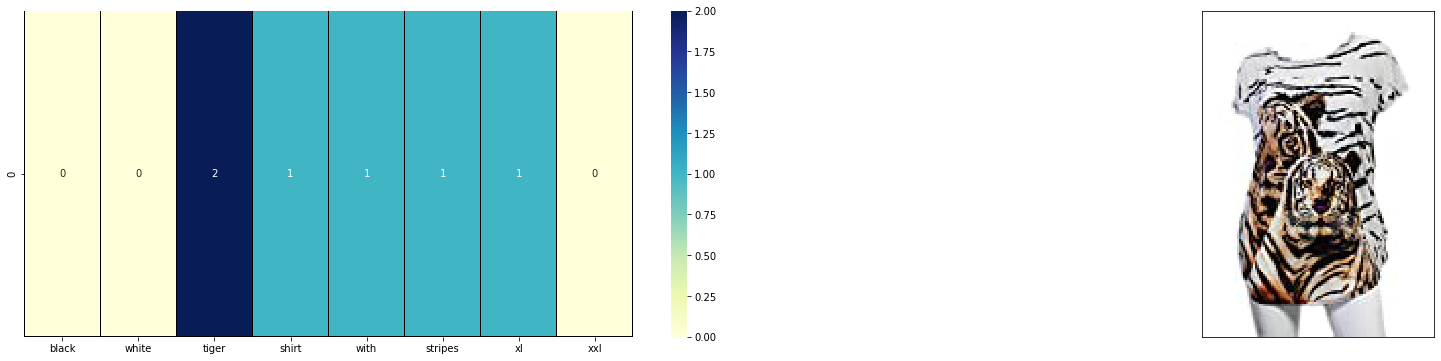

Title :  canvas shirt black xl
ASIN :  B0088PMZ16
Euclidean distance :  2.8284271247461903


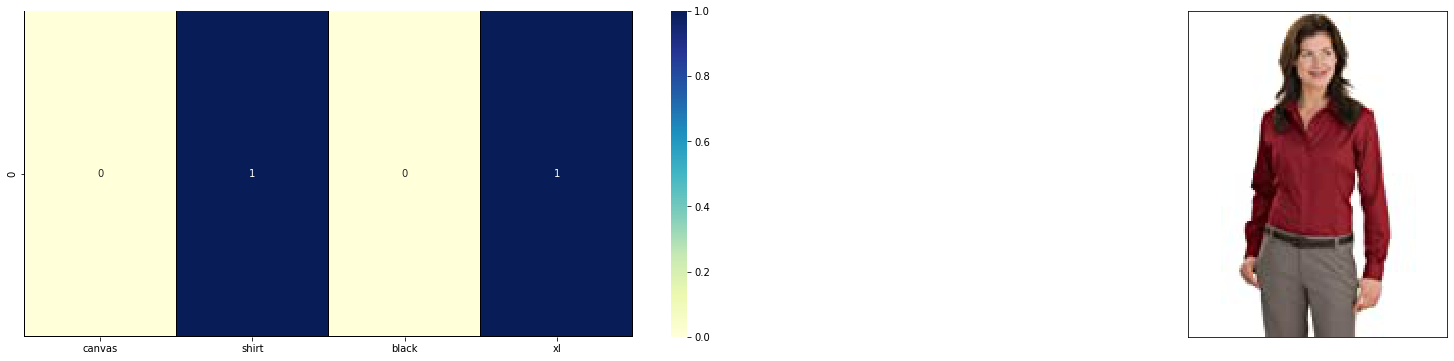

Title :  syndicate beavis woman shirt xl
ASIN :  B01HZX2GQ0
Euclidean distance :  3.0


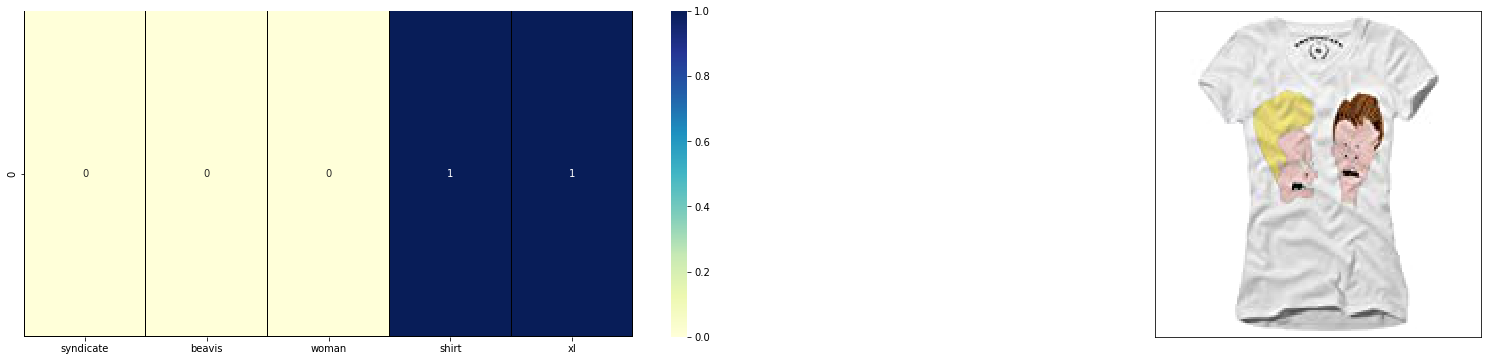

Title :  notorious womens shirt
ASIN :  B01NC2WV6F
Euclidean distance :  3.0


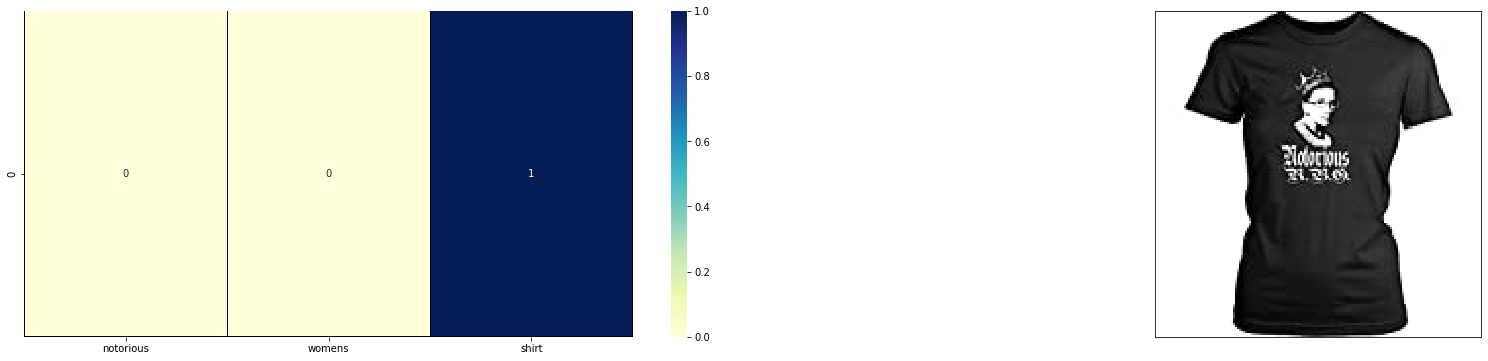

Title :  zebra wild animals women shirt xl new
ASIN :  B01N3SZB62
Euclidean distance :  3.0


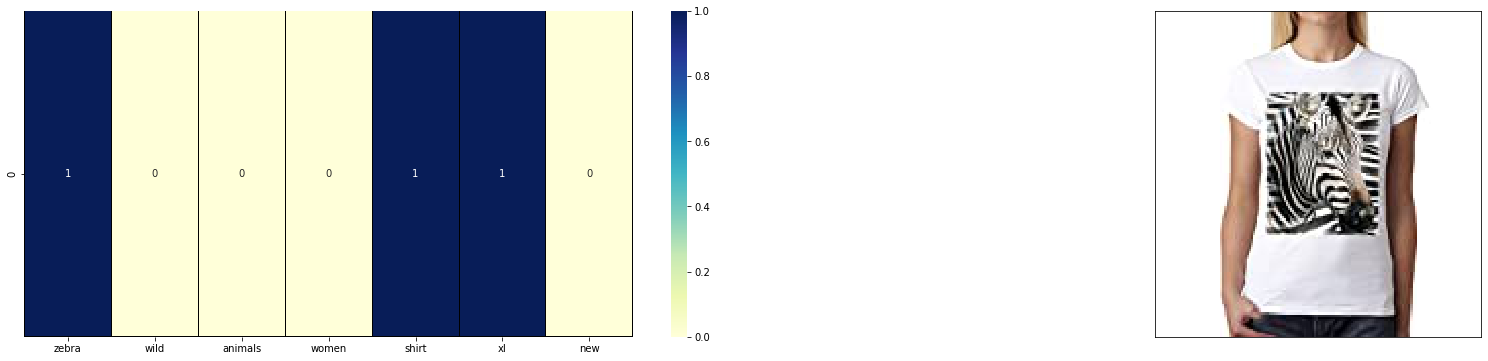

In [61]:
#Top products using BOW

vectorizer = CountVectorizer()
Vec = vectorizer.fit_transform(data['title'])

a=plot_heatmap_image(Vec,data,6288,top=10)